# Admixture

* I estimated admixture proportions using NGSadmix with genotype likelihoods across all samples (minus related individuals) in each pair of urban-rural environement estimated in ANGSD
 - I ran all K values from 2 to 10 10 times, each with a different random seed
 - Uses same 4fold SNPs as above
* I used Evanno's delta-K method implemented in CLUMPAK to estimate the upper-most level of structure (i.e., "optimal" K)

## Setup

In [1]:
# Libraries
library("IRdisplay")
library(tidyverse)
library(wesanderson)
library(RColorBrewer)
library(ggpubr)


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# Path to results for this project
results_prefix <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/'


In [3]:
# Function to load NGSadmix log files
load_ngsadmix_log <- function(path){
    seed <- as.numeric(str_extract(basename(path), pattern = '(?<=seed)[0-9]+(?=\\.log)'))
    
    logfile <- readLines(path)[9]  ## 9 index is for line with likelihood
    like <- as.numeric(str_extract(logfile, pattern = '(?<=like=)-[0-9]+\\.[0-9]+'))
    
    df_out <- data.frame(seed = seed, like = like)
    return(df_out)
}

In [38]:
# File of samples order per city
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")
samples<-as.data.frame(read.table("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t"))
samples$site<-gsub("u","tem",as.character(samples$site))
samples$site<-gsub("r","Rural",as.character(samples$site))
samples$site<-gsub("tem","Urban",as.character(samples$site))
for (city in list){
    detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/",city,"/",city,"_4fold_lowCovRemoved_bams.list"))
    detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
    detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
    name <-paste0(city,'_order_detail')
    tmp <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
    assign(name,tmp)
    }
    

## Albuquerque

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 3"

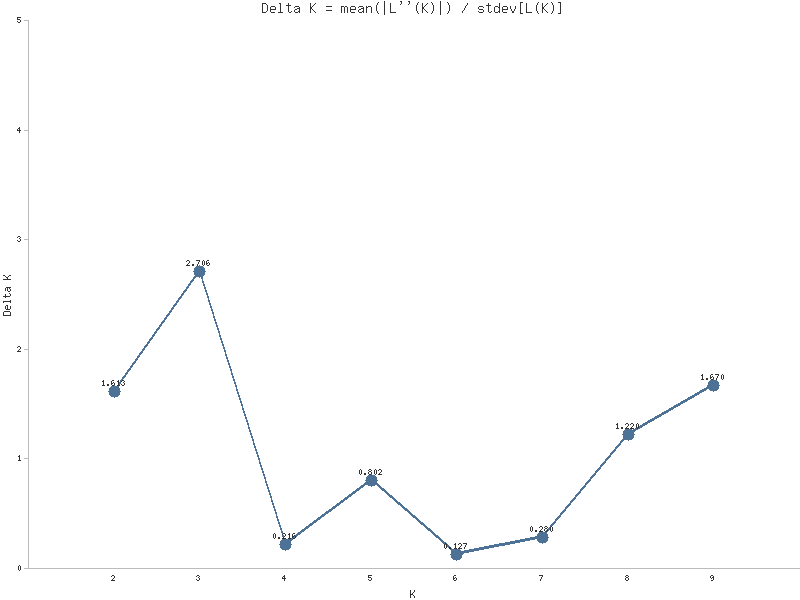

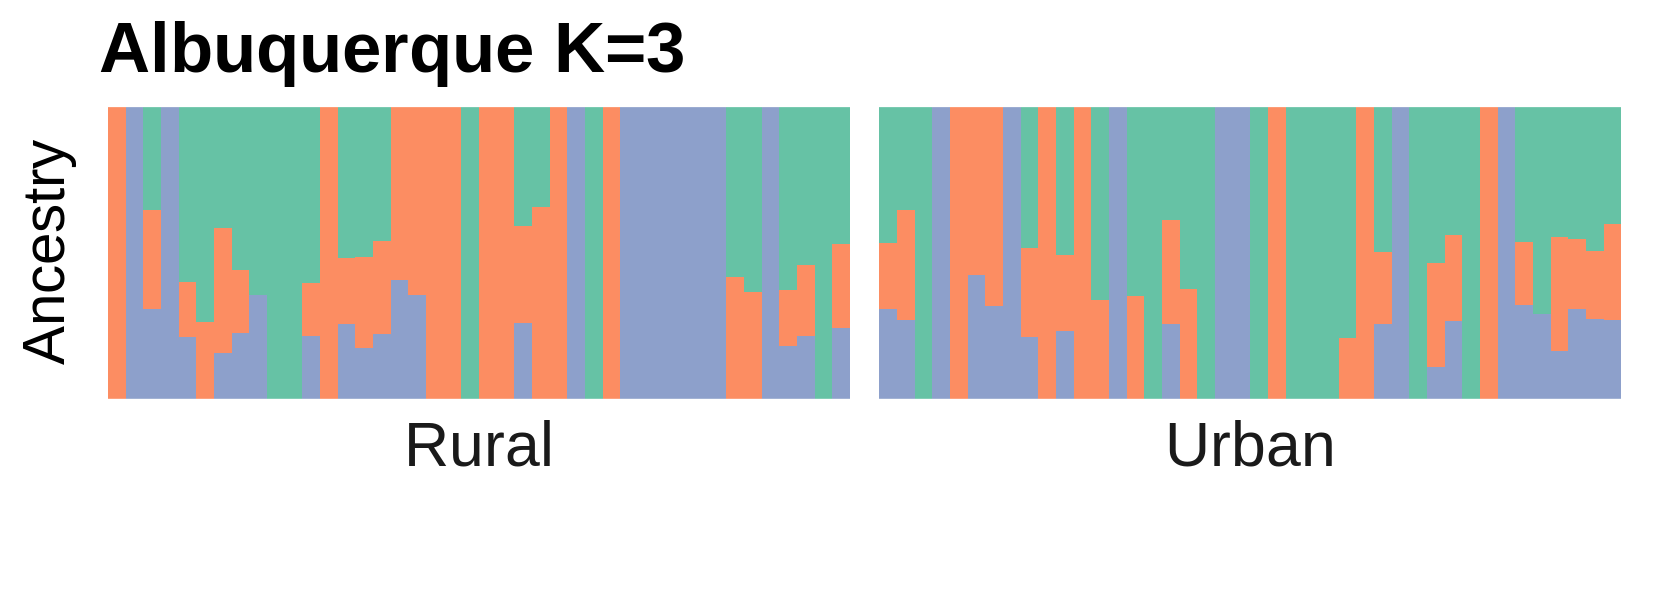

In [116]:
city <- 'Albuquerque'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Albuquerque_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')
kplot_Albuquerque <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Albuquerque K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Albuquerque_K3.png",
  plot = kplot_Albuquerque,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Albuquerque_K3.png"
display_png(file=path_to_kplot)

## Antwerp

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

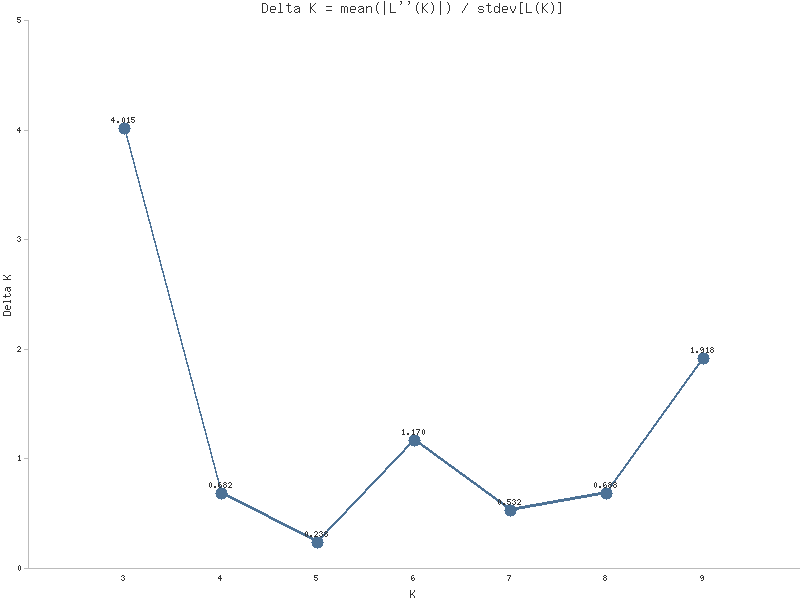

In [117]:
city <- 'Antwerp'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



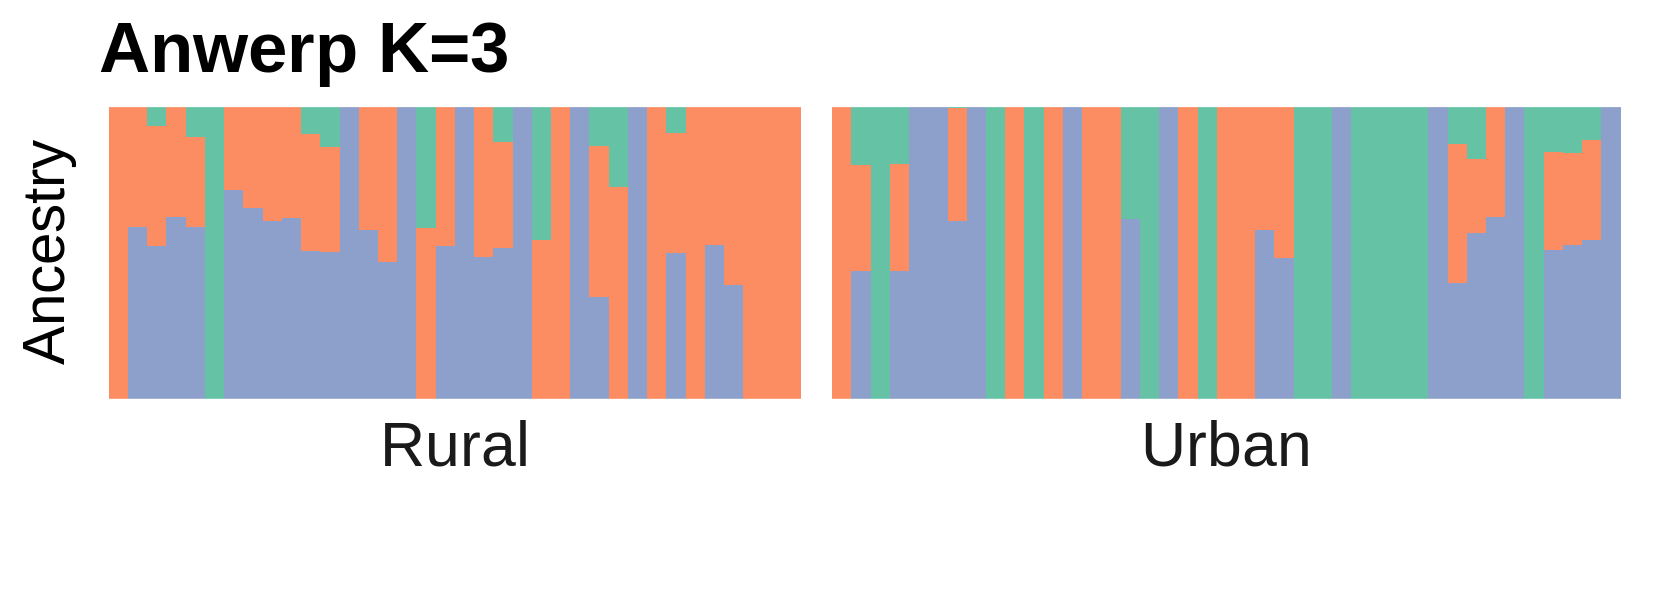

In [118]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Antwerp_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Antwerp <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Anwerp K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Antwerp_K3.png",
  plot = kplot_Antwerp,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Antwerp_K3.png"
display_png(file=path_to_kplot)

## Armidale

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

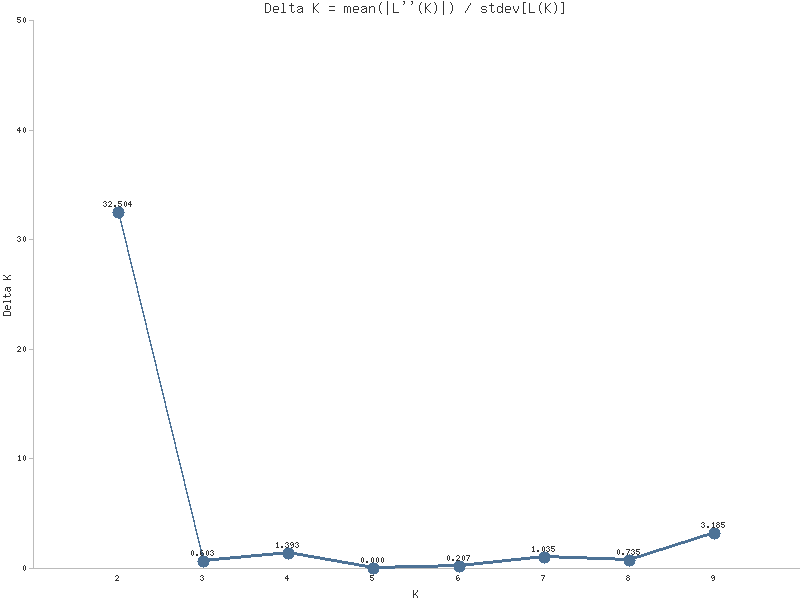

In [119]:
city <- 'Armidale'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



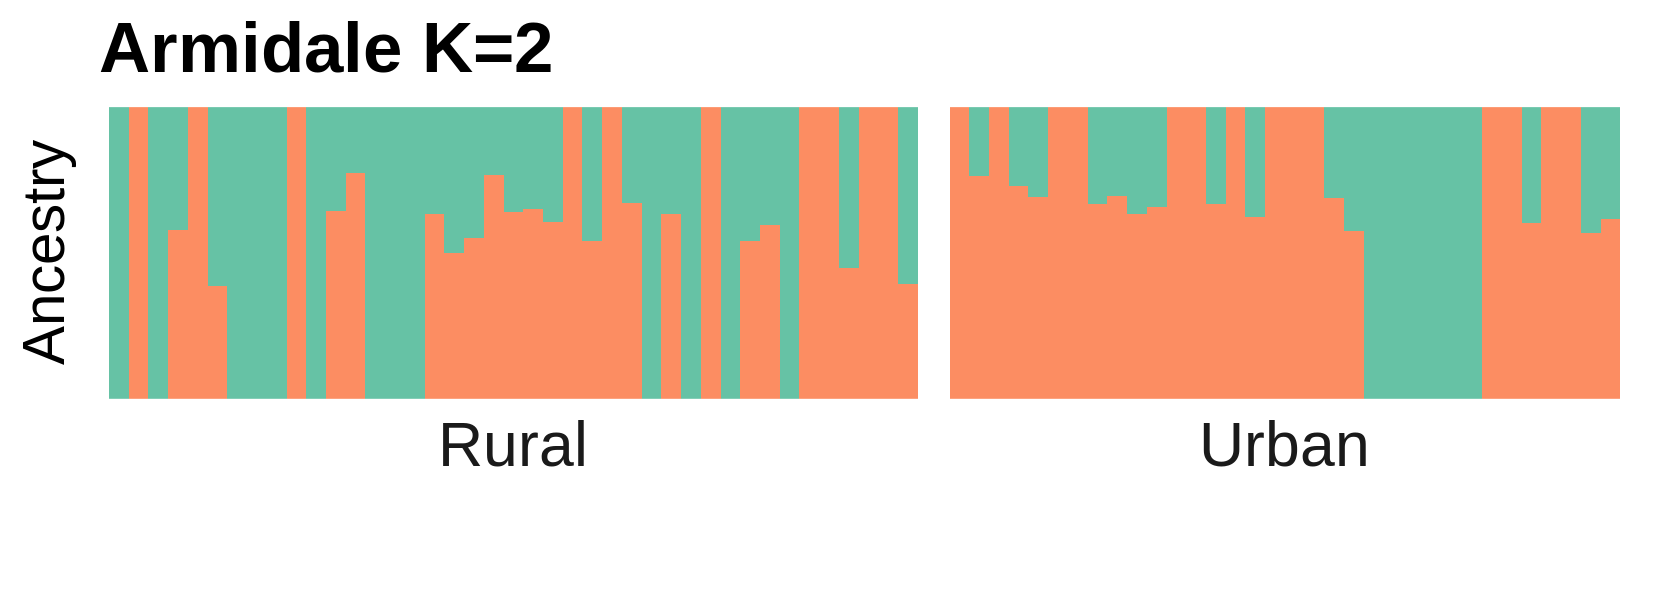

In [120]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Armidale_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Armidale <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Armidale K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


ggsave(
  "ADMIX_Armidale_K2.png",
  plot = kplot_Armidale,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Armidale_K2.png"
display_png(file=path_to_kplot)

## Athens

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

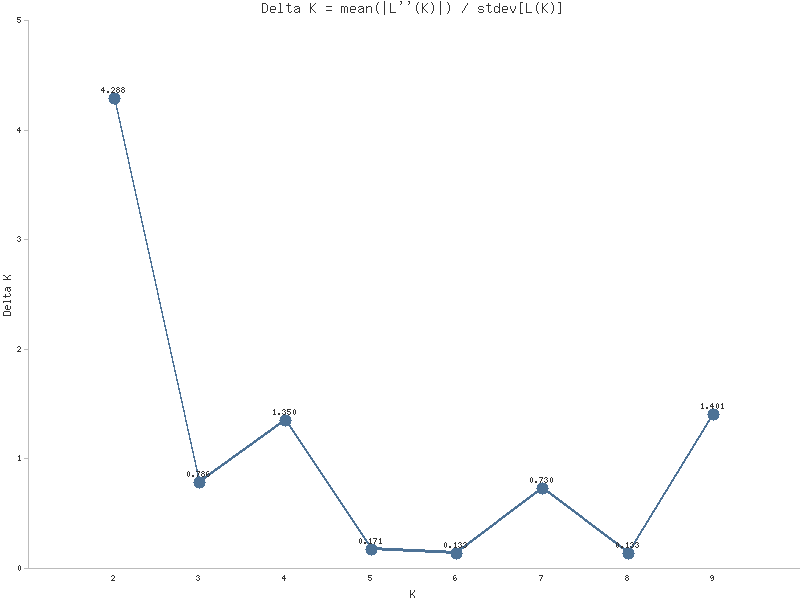

In [121]:
city <- 'Athens'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



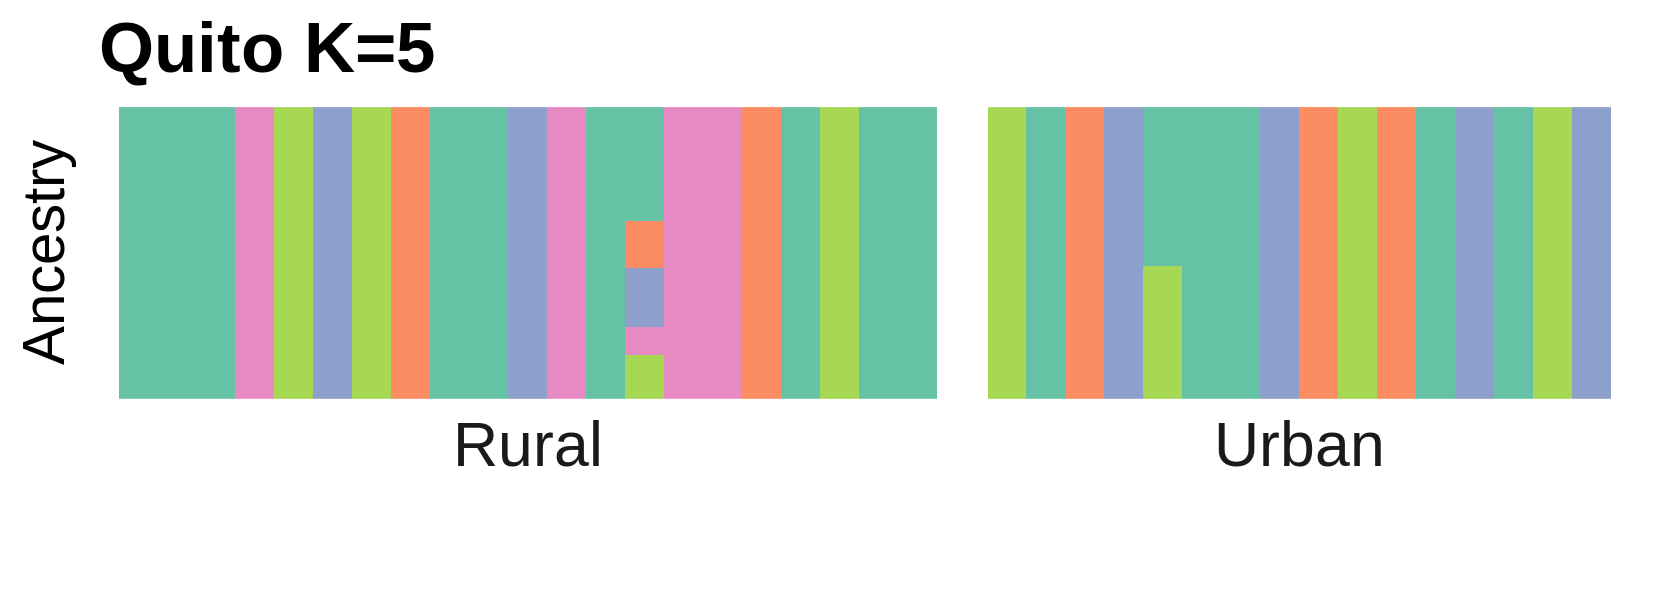

In [122]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Athens_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Athens <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Athens K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


ggsave(
  "ADMIX_Athens_K2.png",
  plot = kplot,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Athens_K2.png"
display_png(file=path_to_kplot)

## Buenos_Aires

[1] "Mon Dec  5 21:55:28 2022: Optimal K by Evanno is: 3"

[1] "3"

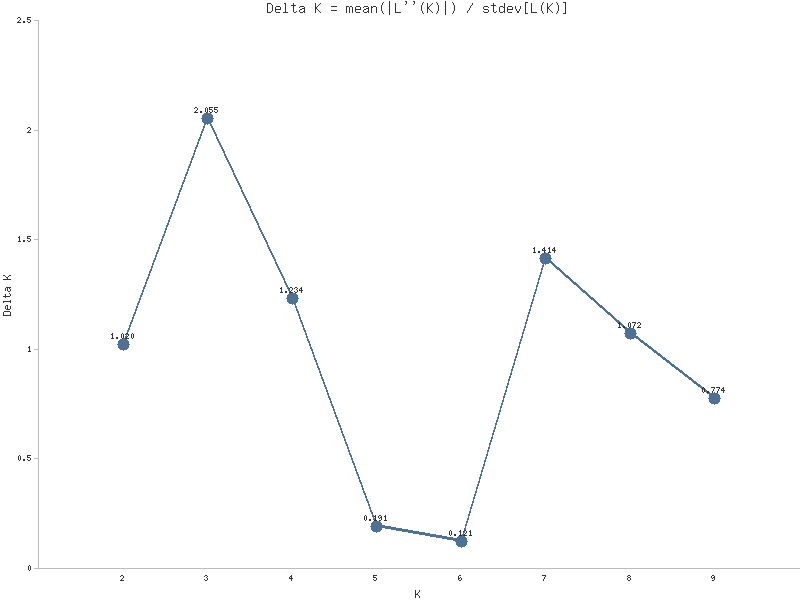

In [123]:
city <- 'Buenos_Aires'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



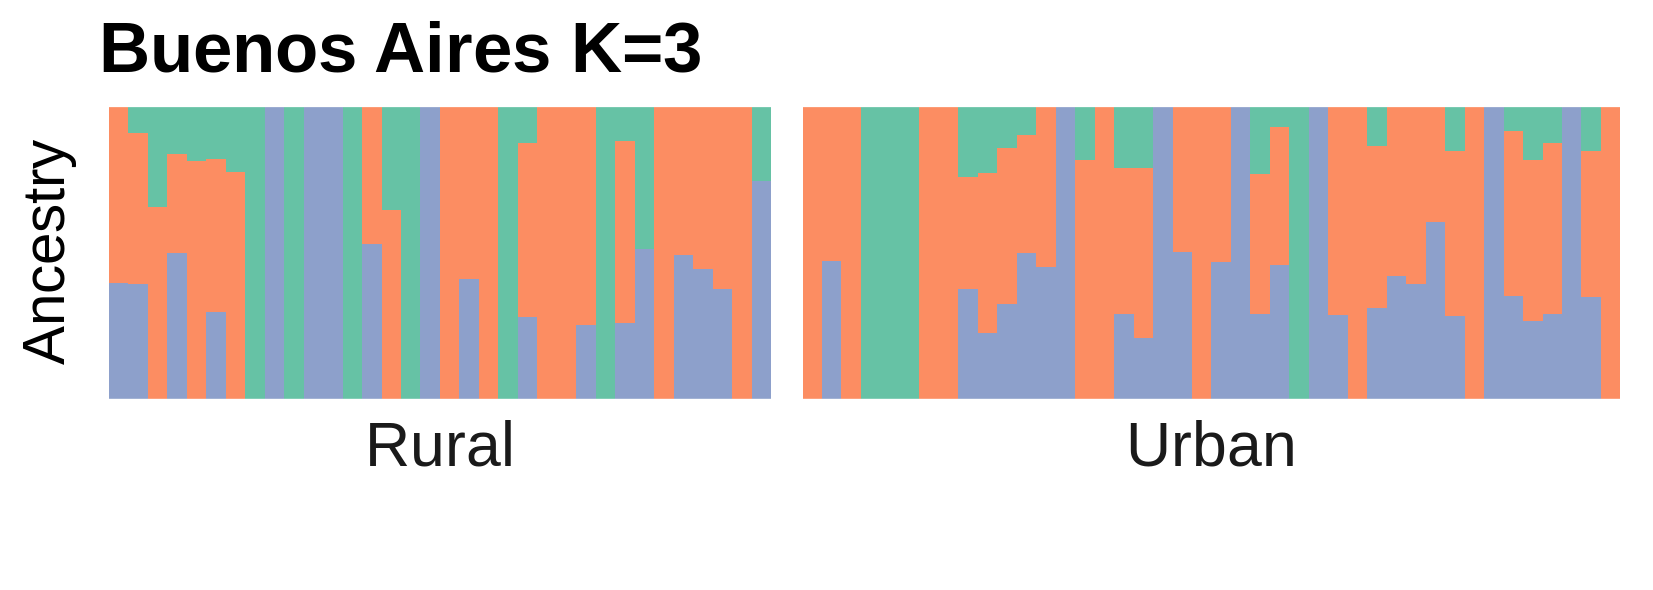

In [124]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Buenos_Aires_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Buenos_Aires <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Buenos Aires K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  #scale_fill_manual(values = cols_admix) + 
  #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  

ggsave(
  "ADMIX_Buenos_Aires_K3.png",
  plot = kplot_Buenos_Aires,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Buenos_Aires_K3.png"
display_png(file=path_to_kplot)

## Calgary

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

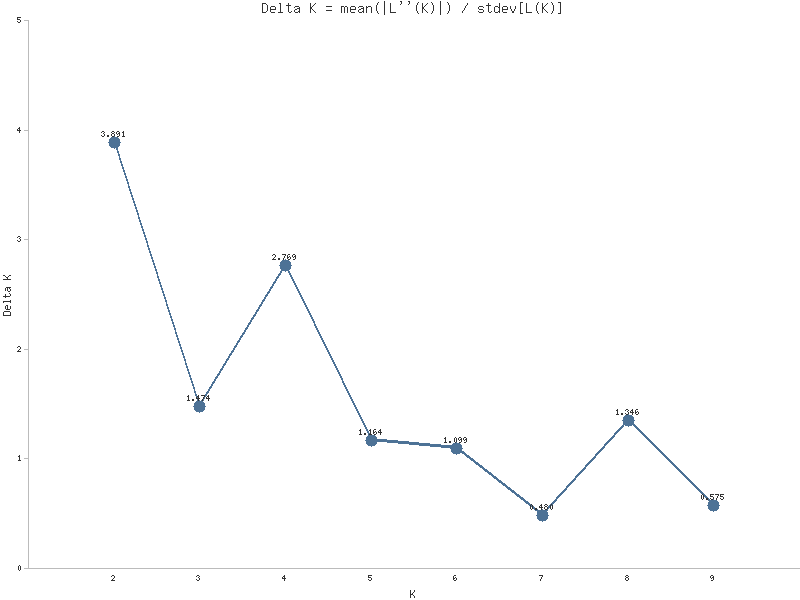

In [125]:
city <- 'Calgary'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



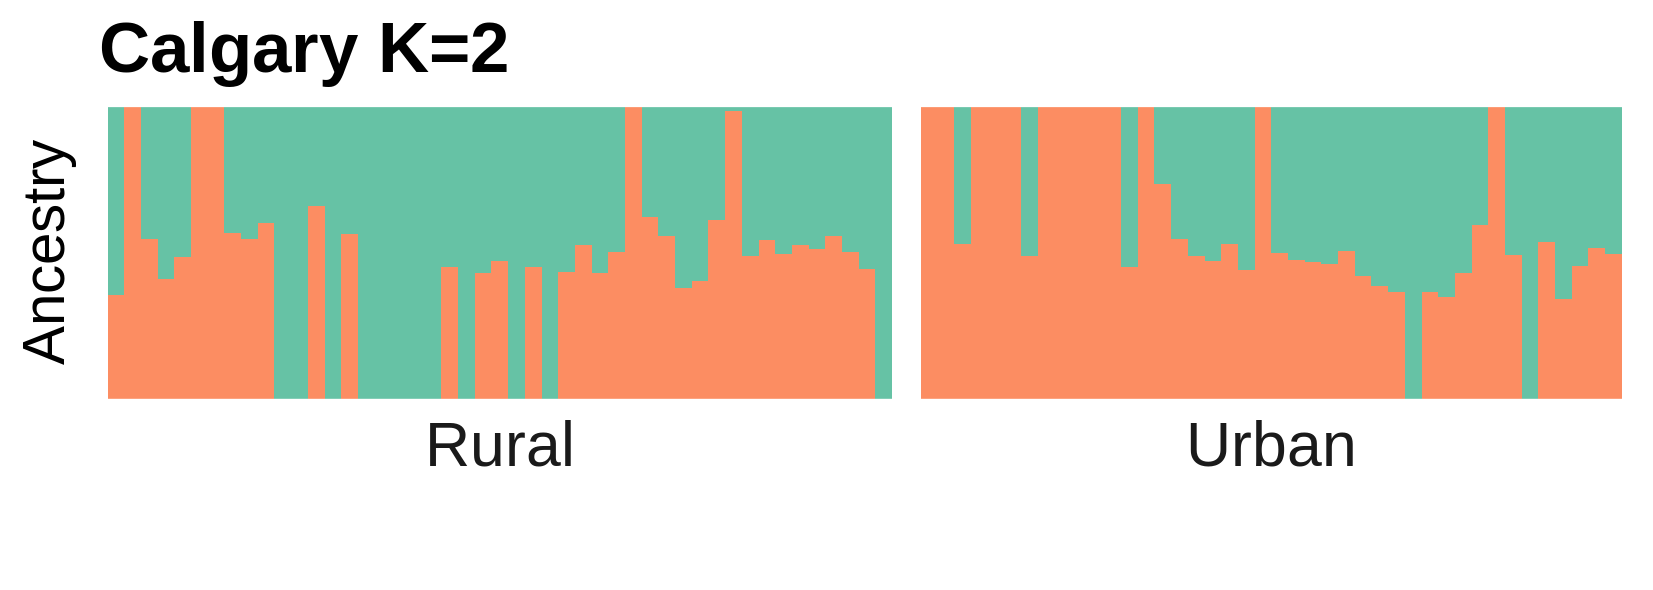

In [126]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Calgary_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

cols_admix <- c('#66C2A5','#FC8D62','#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#6A3D9A')

kplot_Calgary <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Calgary K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  #scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
ggsave(
  "ADMIX_Calgary_K2.png",
  plot = kplot_Calgary,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Calgary_K2.png"
display_png(file=path_to_kplot)

## Cape_Town

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 4"

[1] "4"

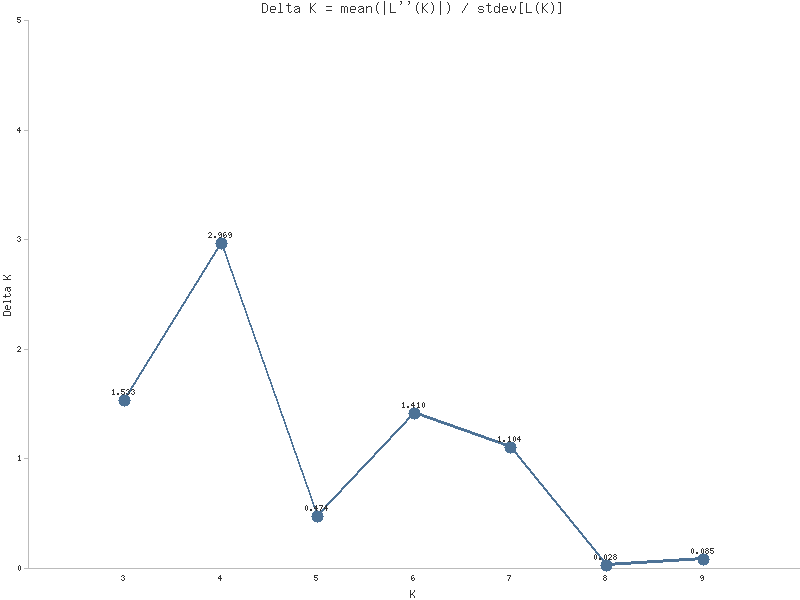

In [127]:
city <- 'Cape_Town'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



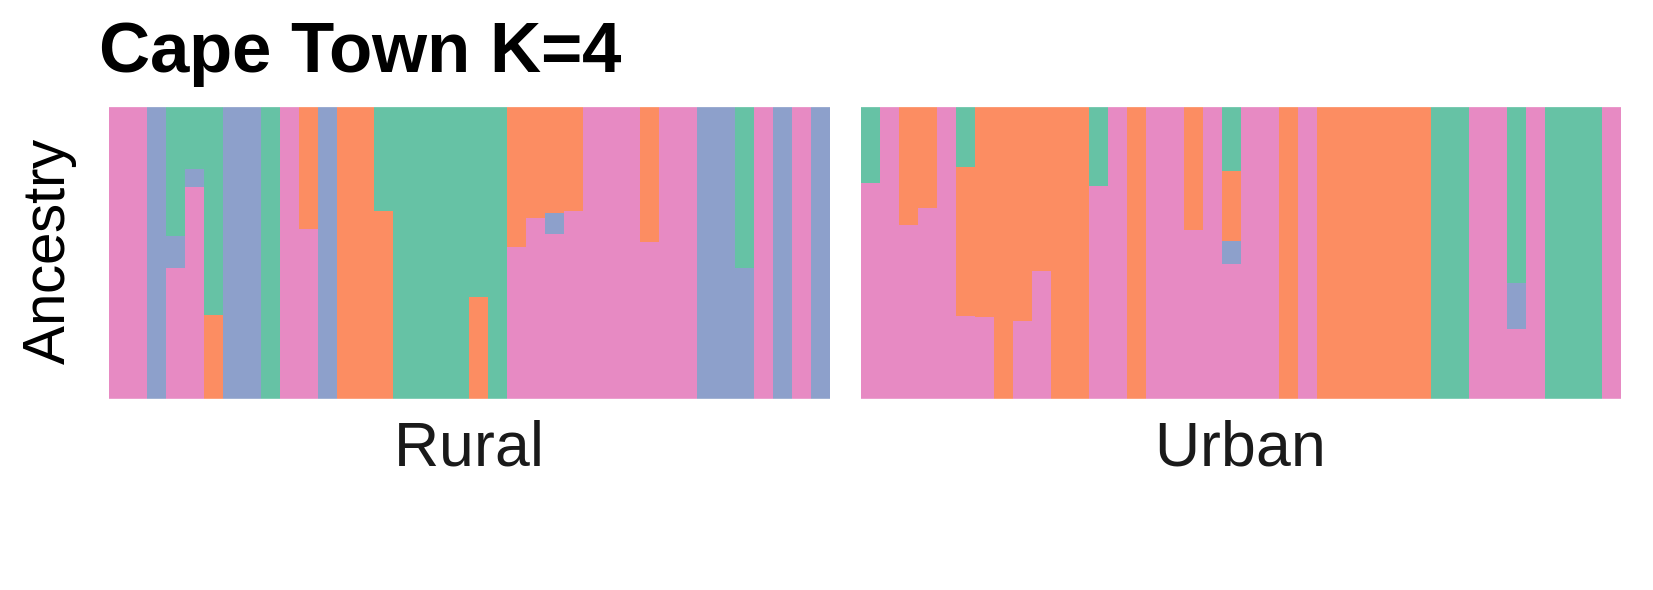

In [128]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., Cape_Town_order_detail) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Cape_Town <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Cape Town K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


ggsave(
  "ADMIX_Cape_Town_K4.png",
  plot = kplot_Cape_Town,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Cape_Town_K4.png"
display_png(file=path_to_kplot)

## Christchurch

[1] "Mon Nov 28 10:57:31 2022: Optimal K by Evanno is: 4"

[1] "4"

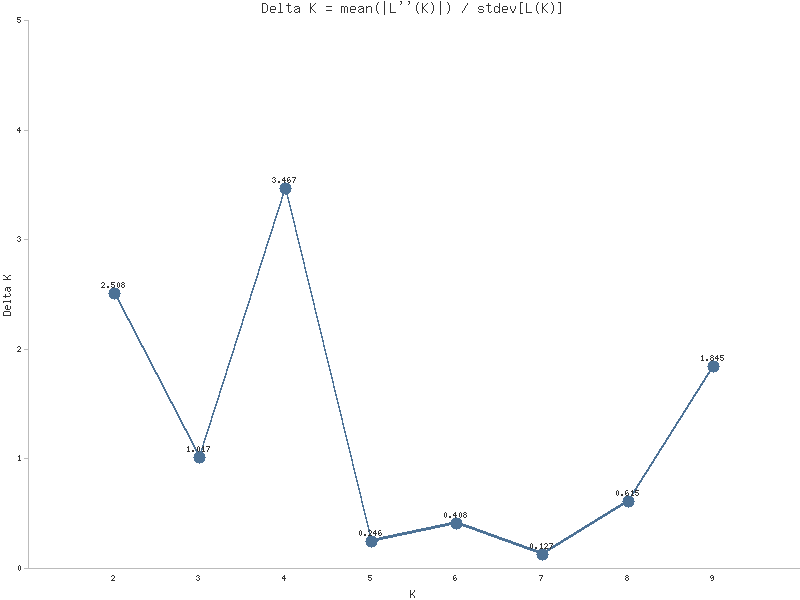

In [130]:
city <- 'Christchurch'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



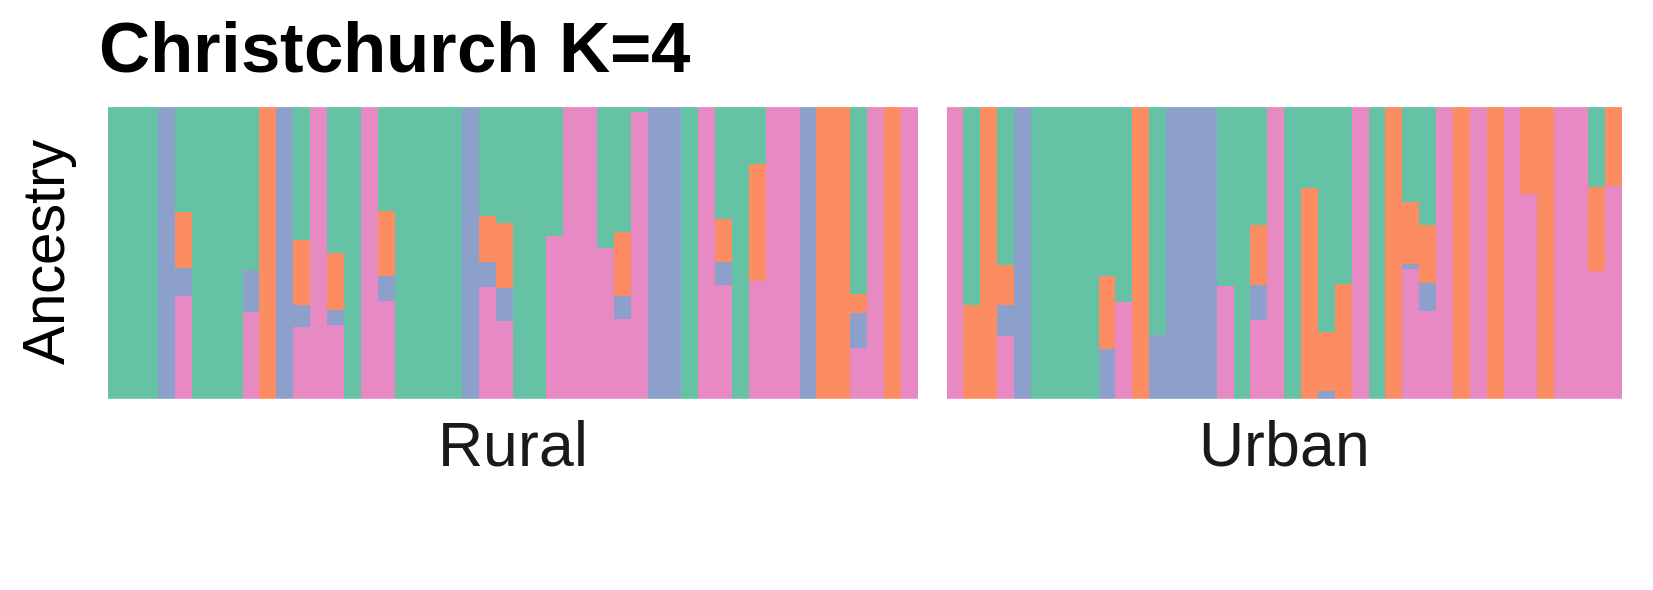

In [131]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., Christchurch_order_detail) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


cols_admix <- c('#66C2A5','#FC8D62','#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#6A3D9A')

kplot_Christchurch <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Christchurch K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
ggsave(
  "ADMIX_Christchurch_K4.png",
  plot = kplot_Christchurch,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Christchurch_K4.png"
display_png(file=path_to_kplot)

## Kunming

[1] "Fri Dec  2 16:46:08 2022: Optimal K by Evanno is: 2"

[1] "2"

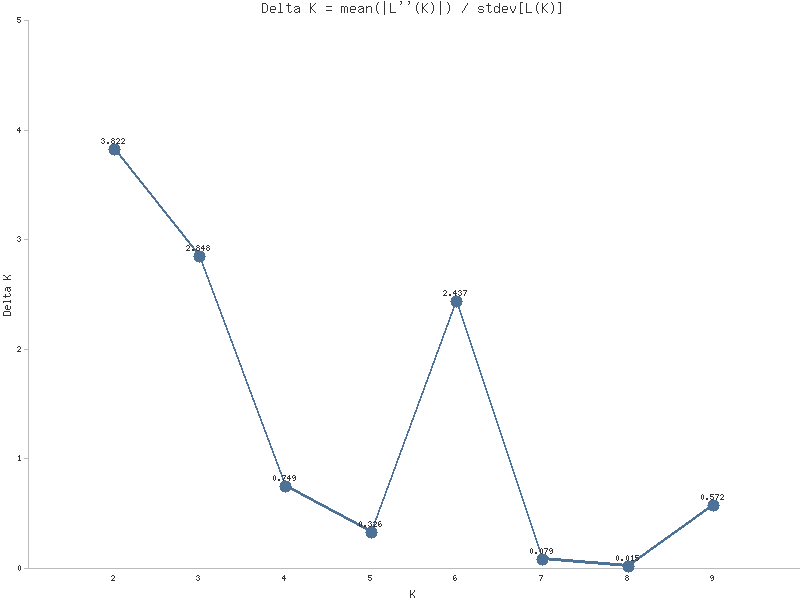

In [132]:
city <- 'Kunming'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



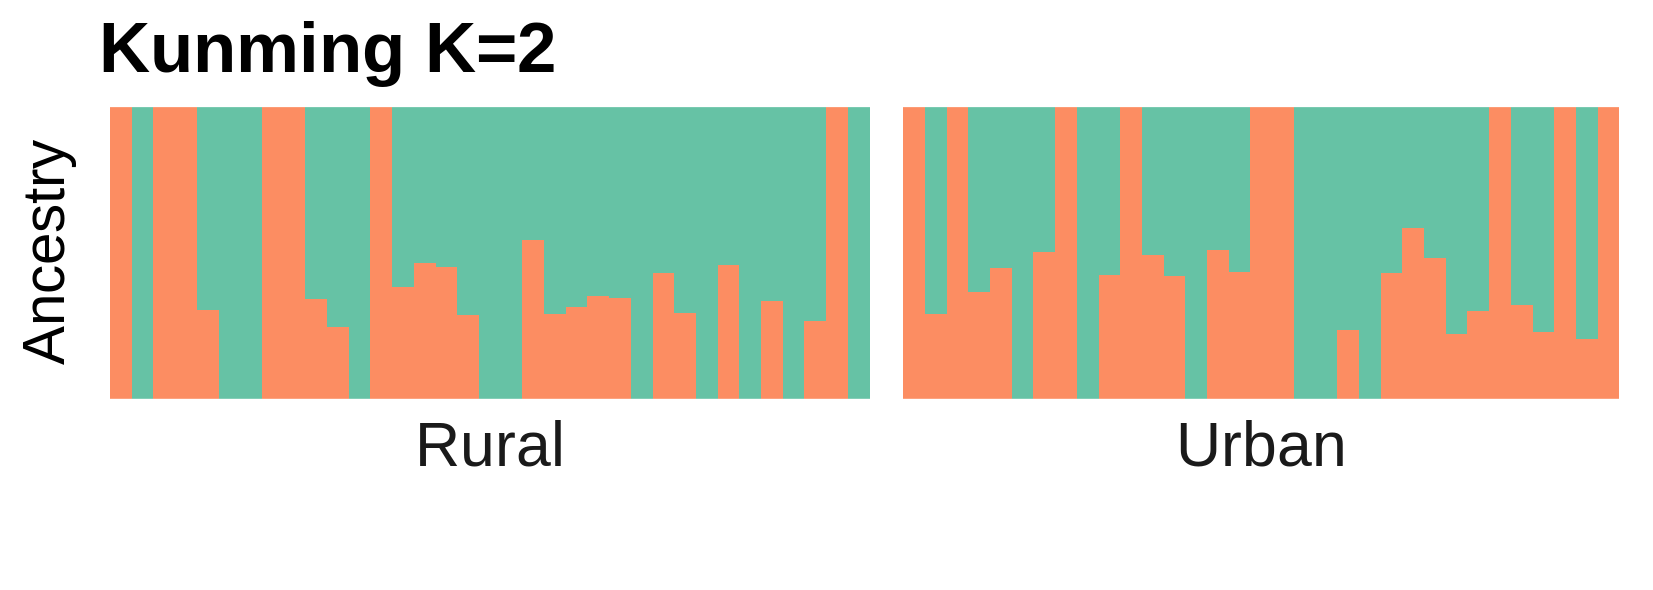

In [133]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Kunming_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Kunming <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Kunming K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Kunming_K2.png",
  plot = kplot_Kunming,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Kunming_K2.png"
display_png(file=path_to_kplot)

## Landshut

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

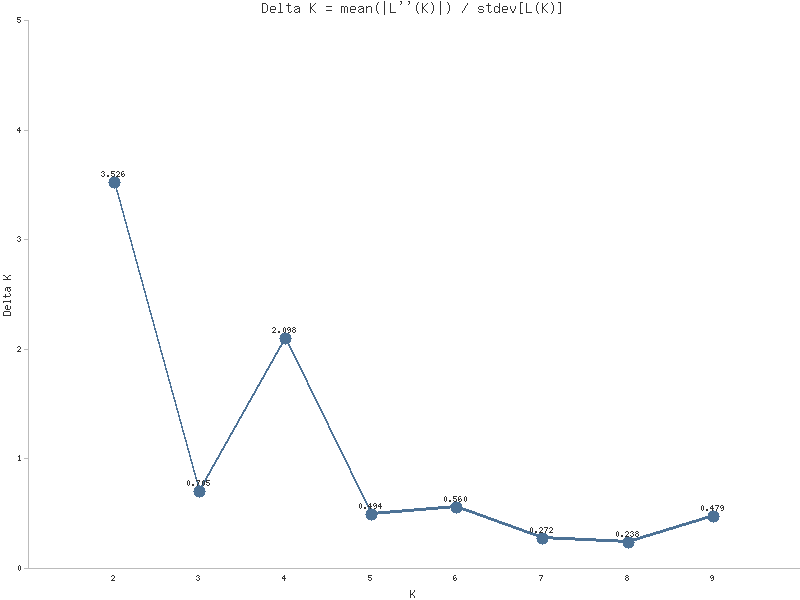

In [134]:
city <- 'Landshut'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



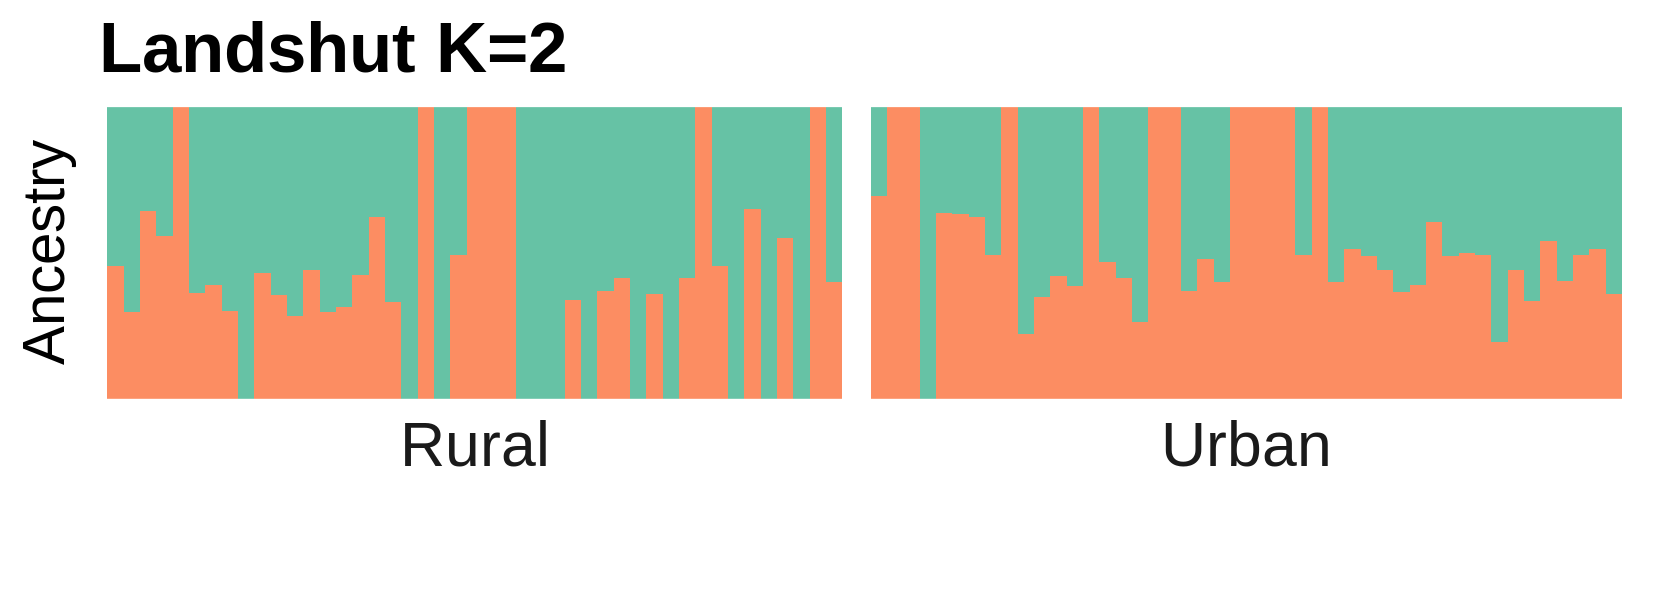

In [135]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Landshut_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Landshut <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Landshut K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 


ggsave(
  "ADMIX_Landshut_K2.png",
  plot = kplot_Landshut,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Landshut_K2.png"
display_png(file=path_to_kplot)

## Linkoping

[1] "Mon Nov 28 10:57:30 2022: Optimal K by Evanno is: 2"

[1] "2"

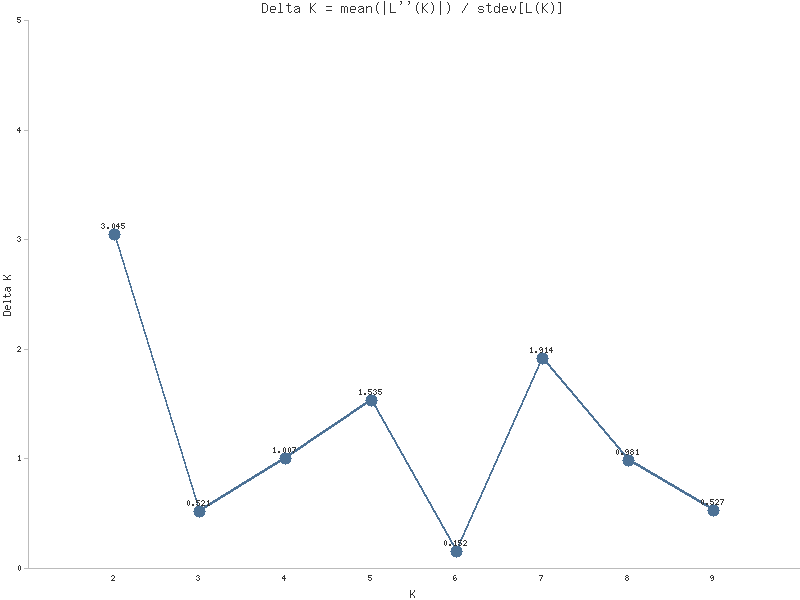

In [136]:
city <- 'Linkoping'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



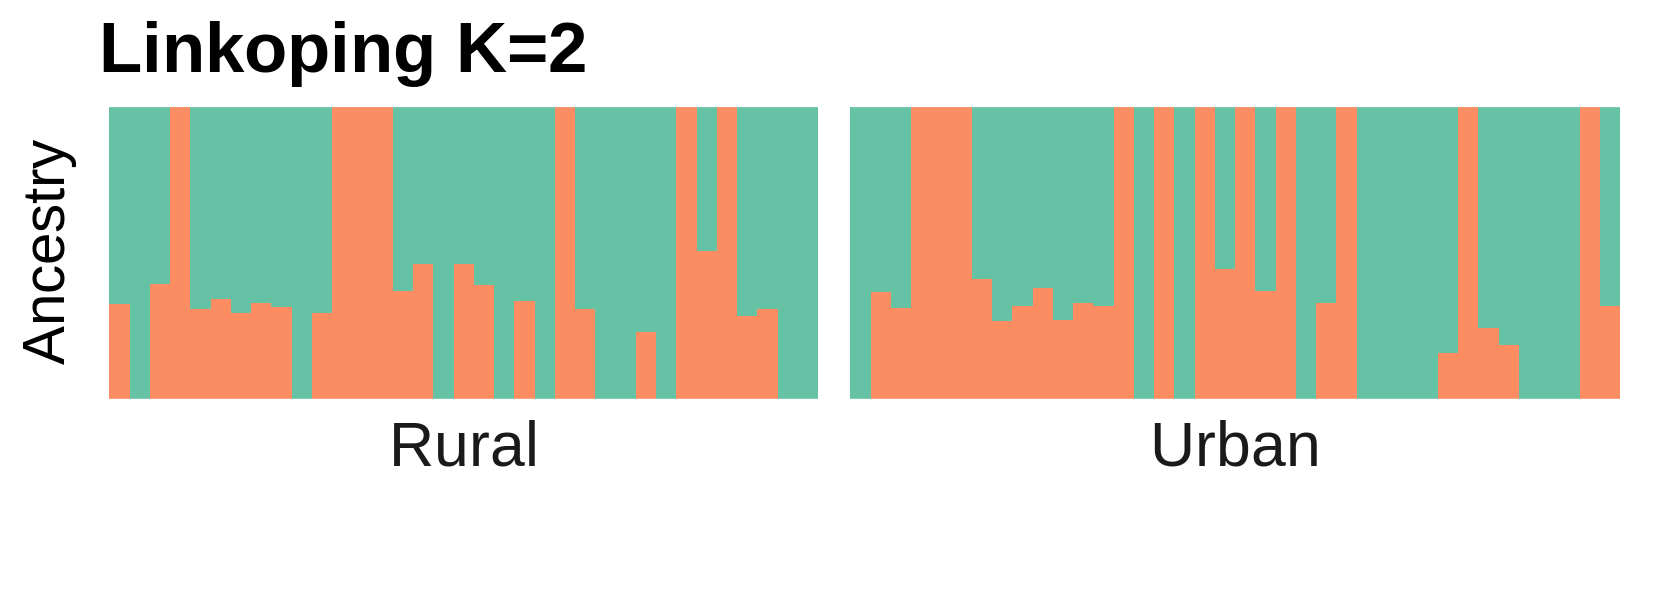

In [137]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Linkoping_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Linkoping <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Linkoping K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Linkoping_K2.png",
  plot = kplot_Linkoping,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Linkoping_K2.png"
display_png(file=path_to_kplot)

## Loja

[1] "Tue Dec  6 17:12:05 2022: Optimal K by Evanno is: 3"

[1] "3"

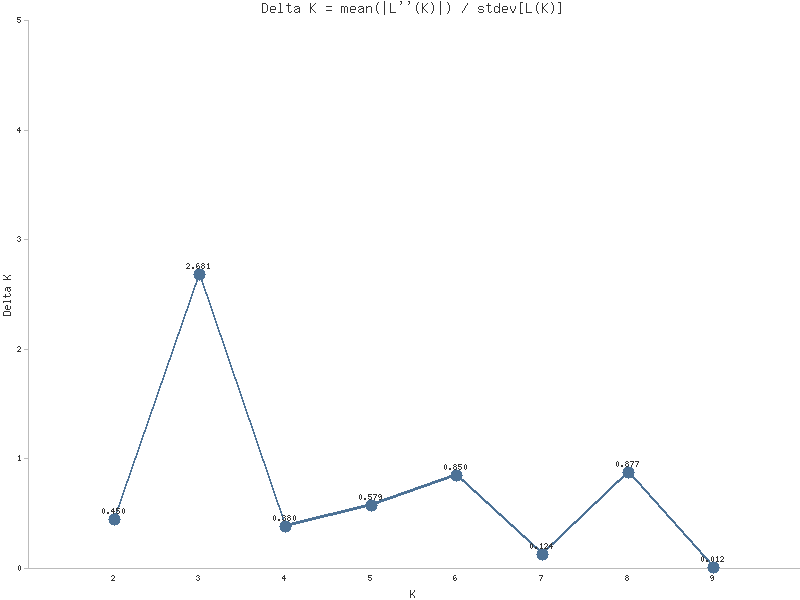

In [138]:
city <- 'Loja'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



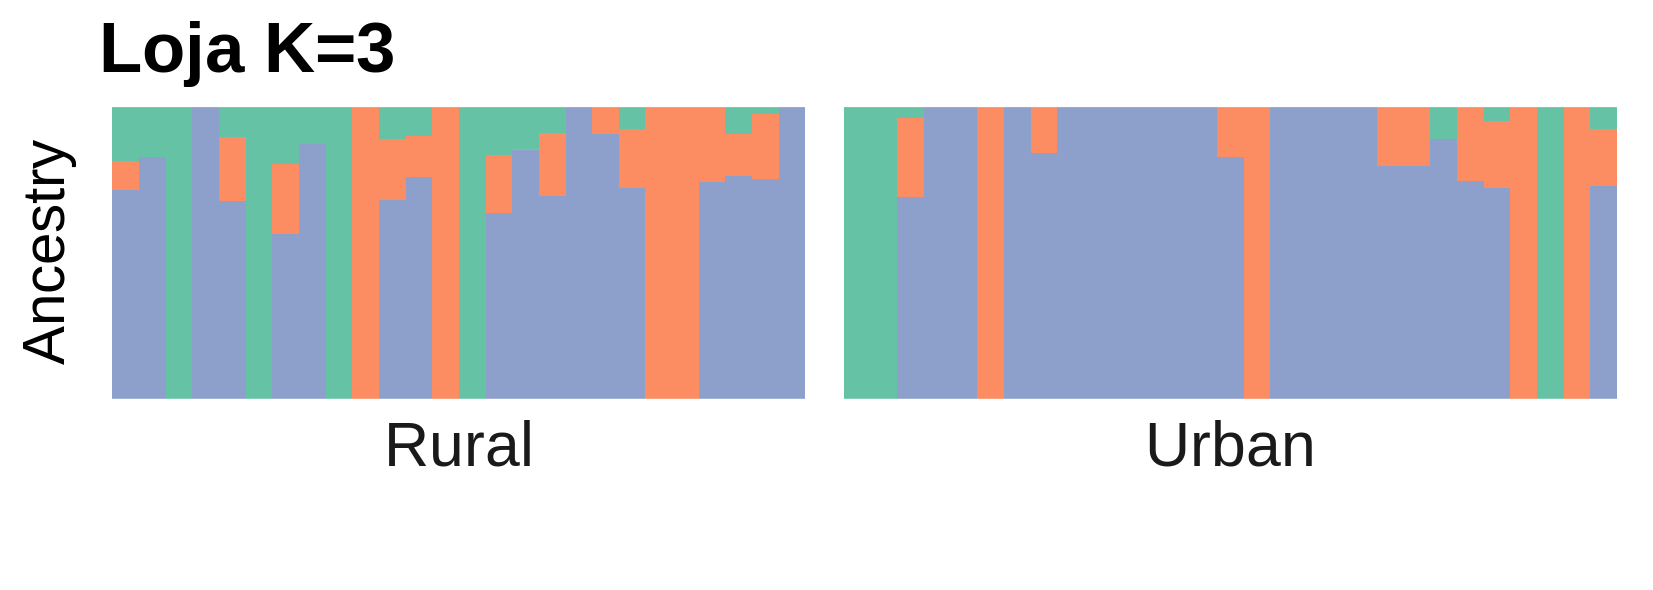

In [139]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Loja_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Loja <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Loja K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Loja_K3.png",
  plot = kplot_Loja,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Loja_K3.png"
display_png(file=path_to_kplot)

## Memphis

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

[1] "3"

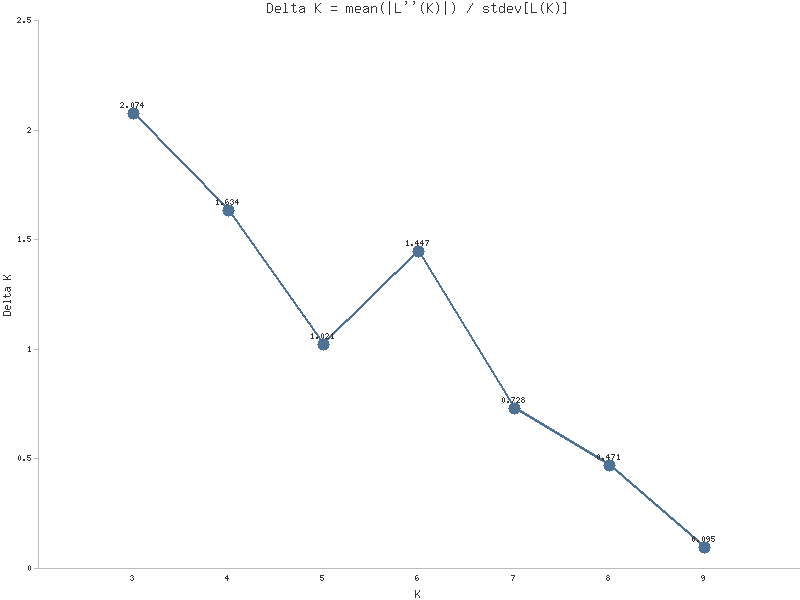

In [140]:
city <- 'Memphis'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



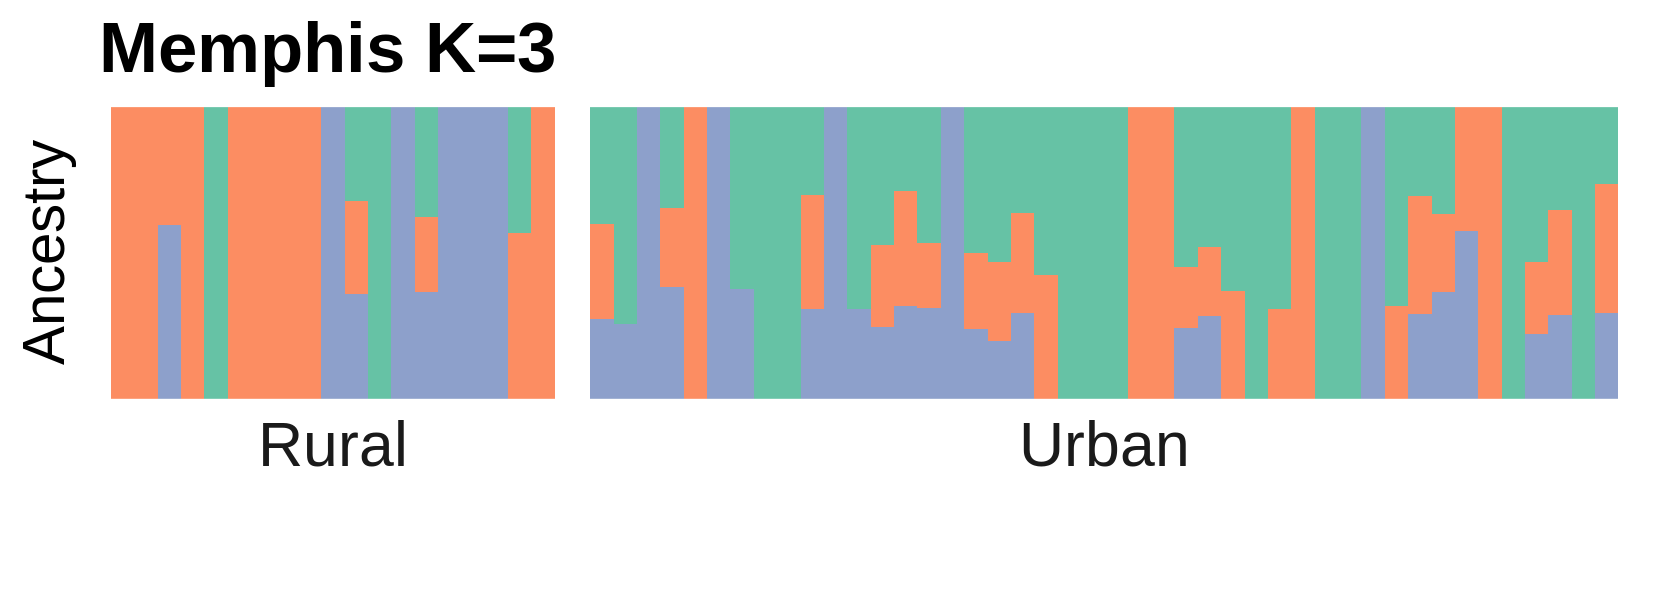

In [141]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Memphis_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Memphis <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Memphis K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Memphis_K3.png",
  plot = kplot_Memphis,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Memphis_K3.png"
display_png(file=path_to_kplot)

## Mexico_City

[1] "Fri Dec  2 16:46:04 2022: Optimal K by Evanno is: 2"

[1] "2"

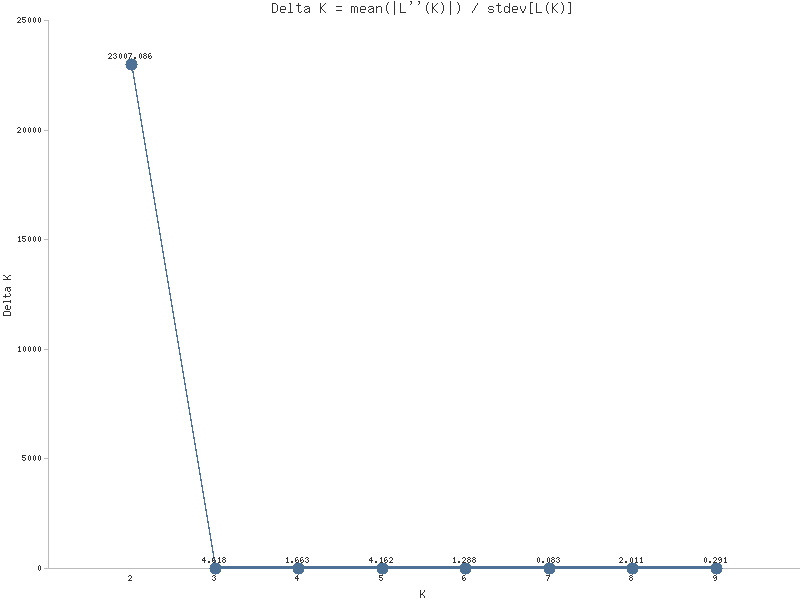

In [150]:
city <- 'Mexico_City'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



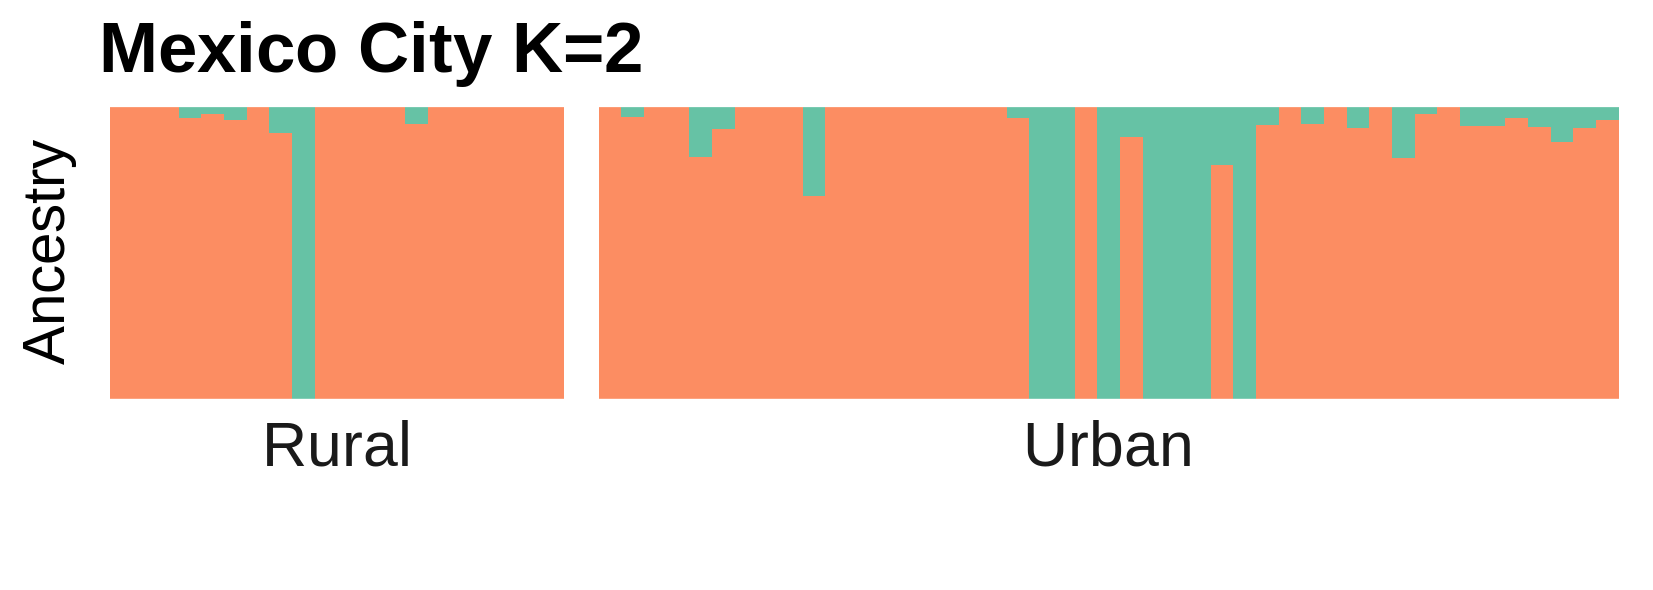

In [151]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Mexico_City_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Mexico_City <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Mexico City K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Mexico_City_K2.png",
  plot = kplot_Mexico_City,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Mexico_City_K2.png"
display_png(file=path_to_kplot)

## Munich

[1] "Fri Dec  2 16:46:03 2022: Optimal K by Evanno is: 2"

[1] "2"

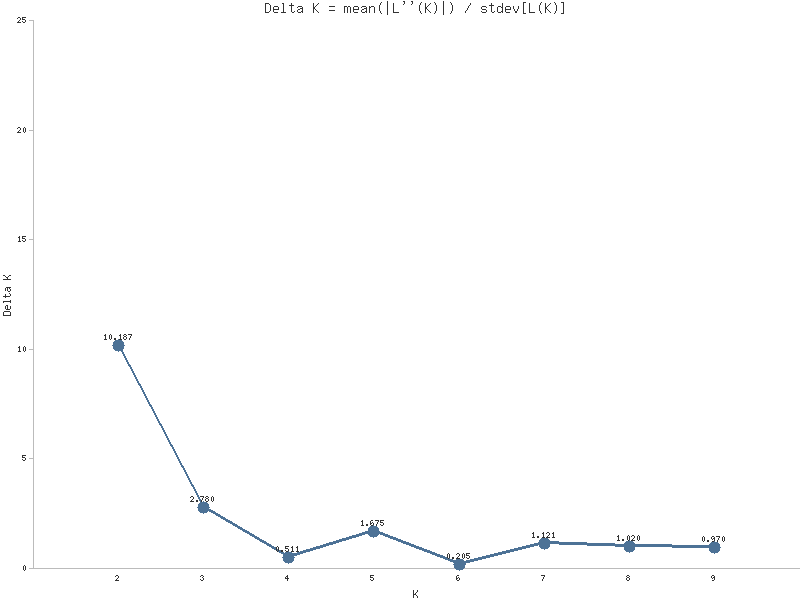

In [176]:
city <- 'Munich'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



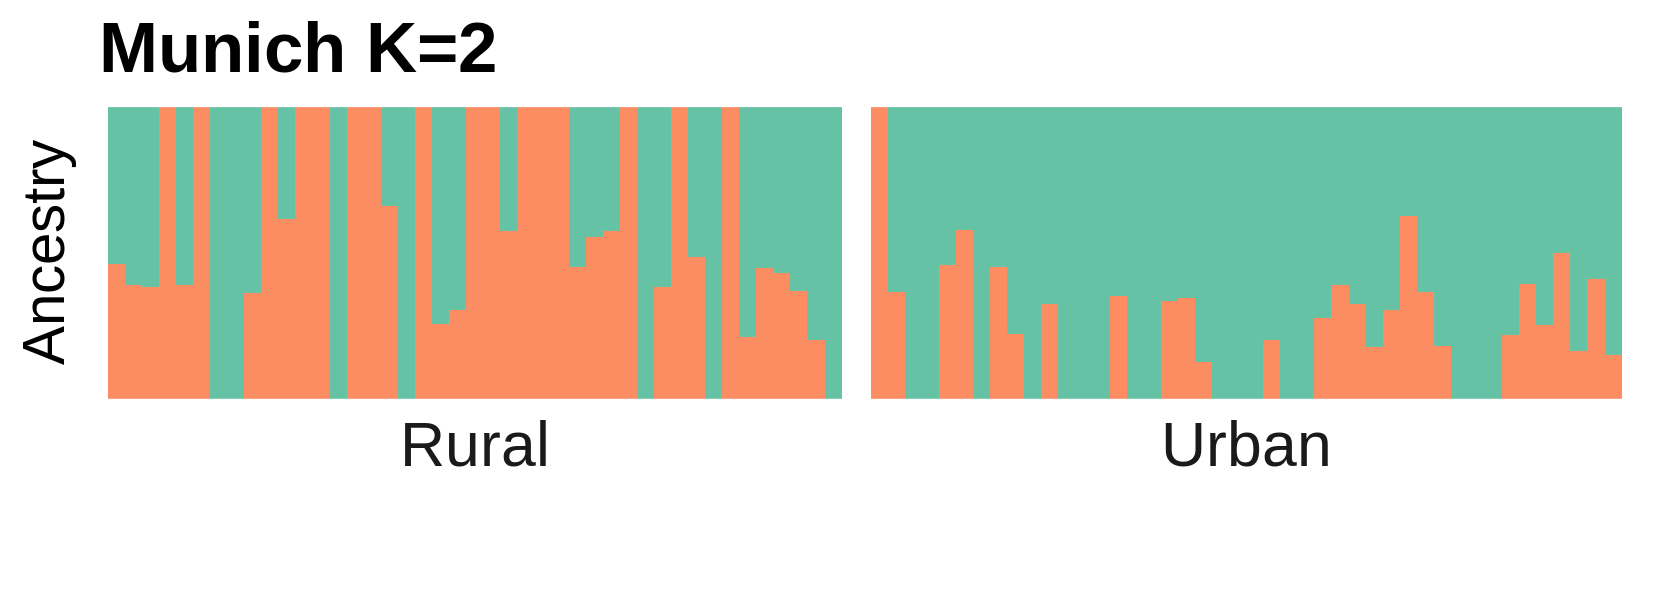

In [177]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Munich_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Munich <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Munich K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 
  
ggsave(
  "ADMIX_Munich_K2.png",
  plot = kplot_Munich,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Munich_K2.png"
display_png(file=path_to_kplot)

## Palmerston_North

[1] "Tue Dec  6 00:39:22 2022: Optimal K by Evanno is: 3"

[1] "3"

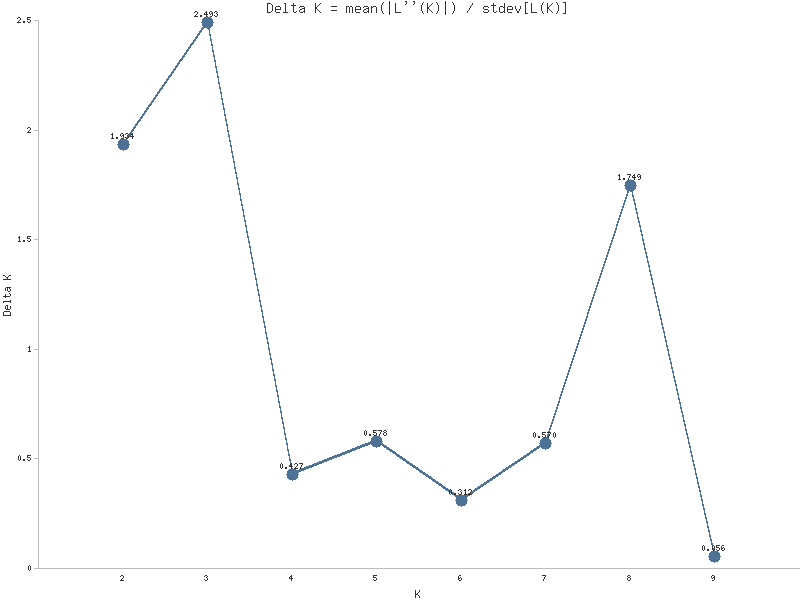

In [156]:
city <- 'Palmerston_North'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



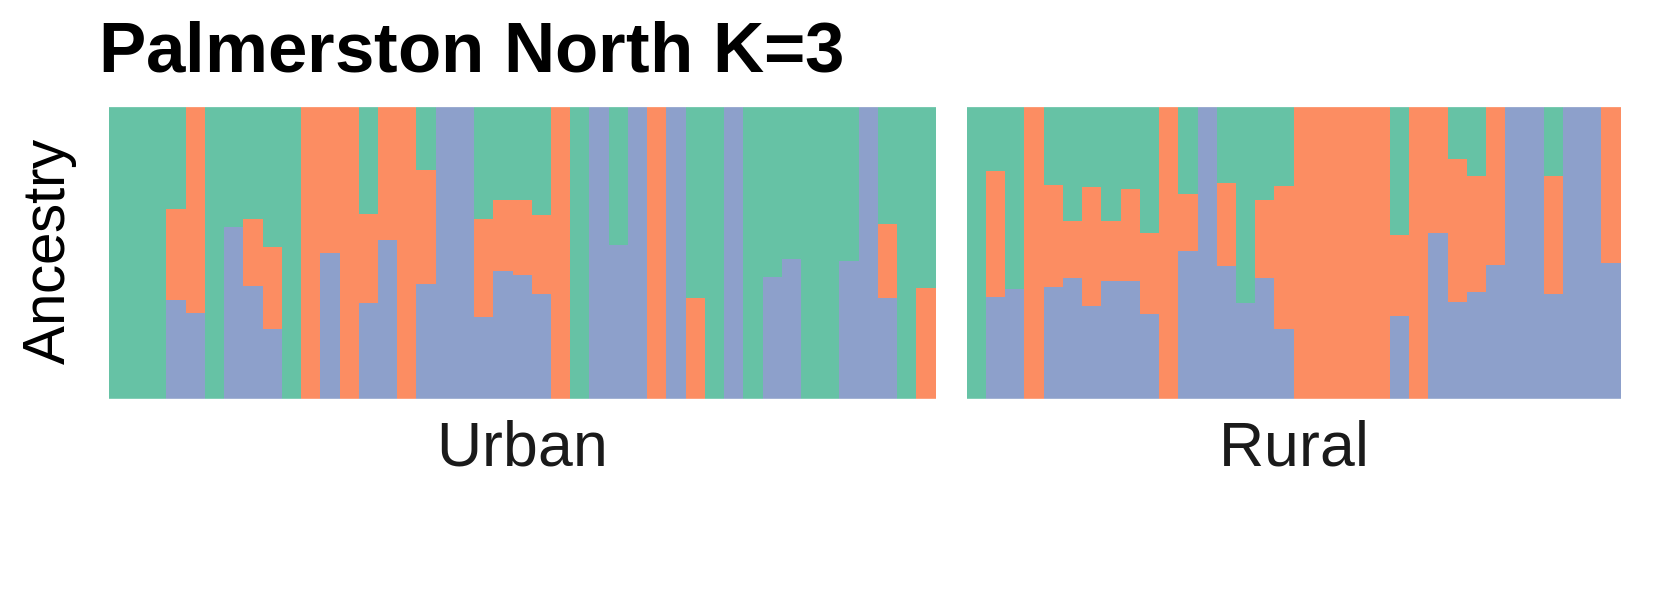

In [157]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Palmerston_North_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Palmerston_North <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Palmerston North K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Palmerston_North_K3.png",
  plot = kplot_Palmerston_North,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Palmerston_North_K3.png"
display_png(file=path_to_kplot)

## Punta Arenas

[1] "Fri Dec  2 18:34:07 2022: Optimal K by Evanno is: 2"

[1] "2"

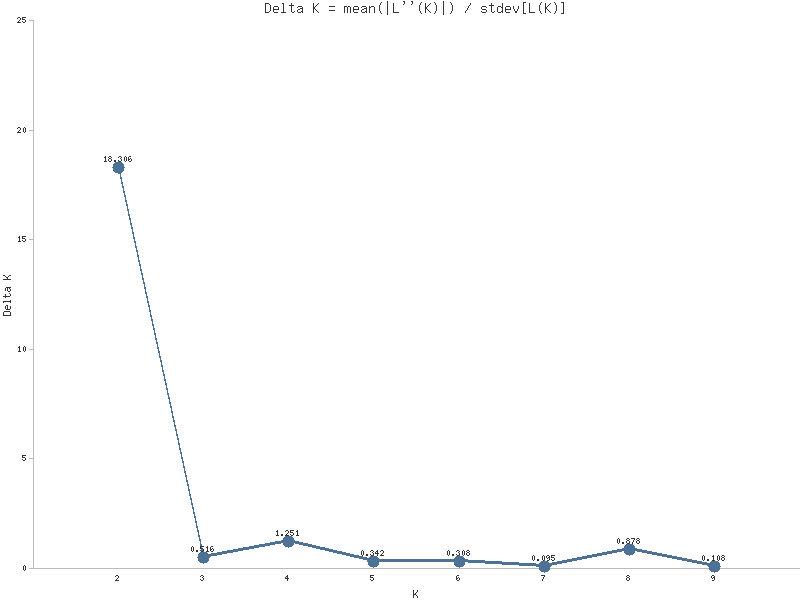

In [158]:
city <- 'Punta_Arenas'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



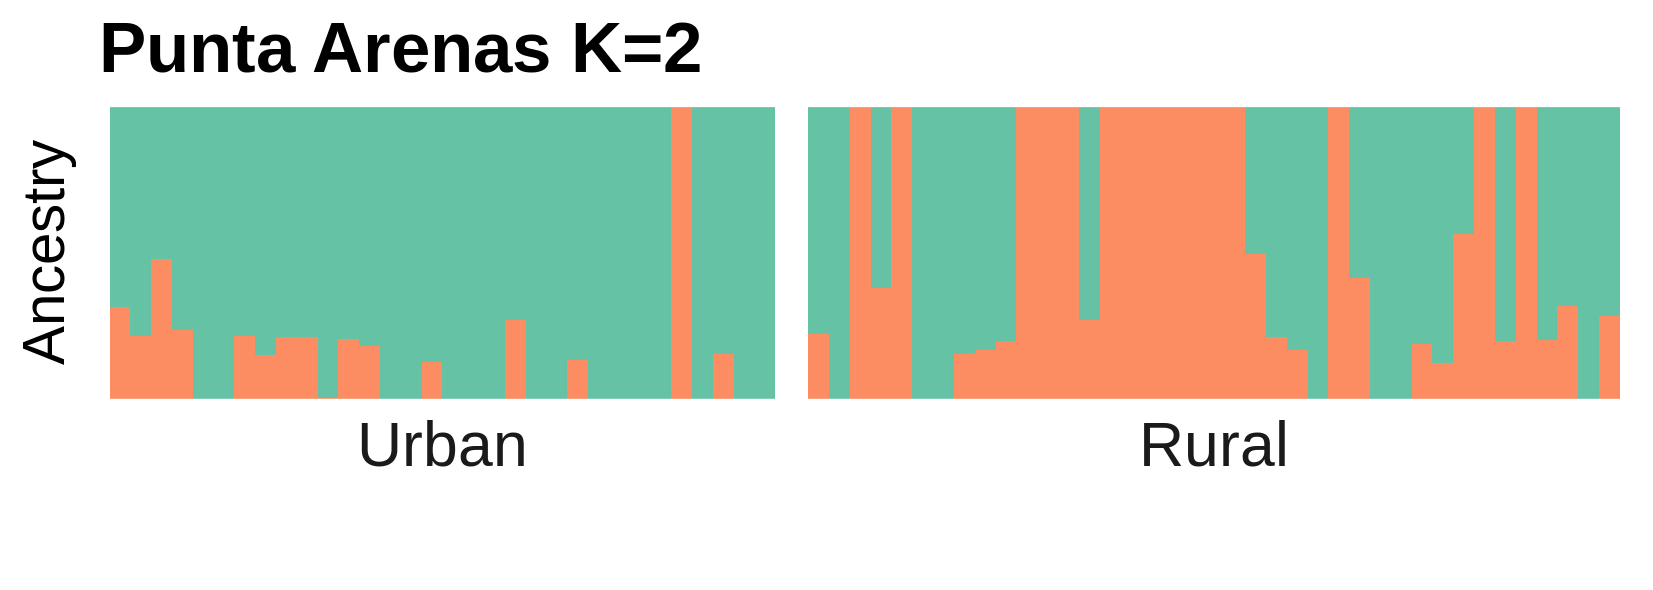

In [159]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Punta_Arenas_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Punta_Arenas <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Punta Arenas K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Punta_Arenas_K2.png",
  plot = kplot_Punta_Arenas,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Punta_Arenas_K2.png"
display_png(file=path_to_kplot)

## Quito

[1] "Tue Dec  6 14:09:14 2022: Optimal K by Evanno is: 5"

[1] "5"

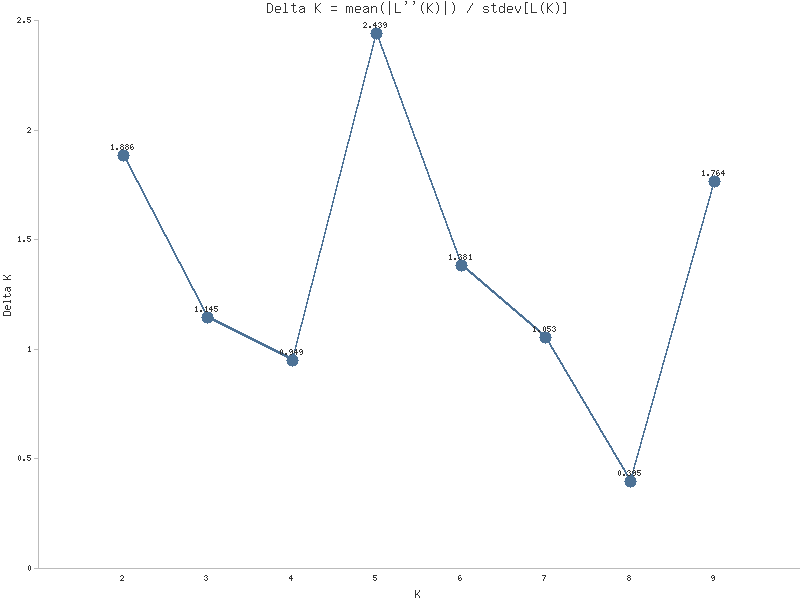

In [160]:
city <- 'Quito'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



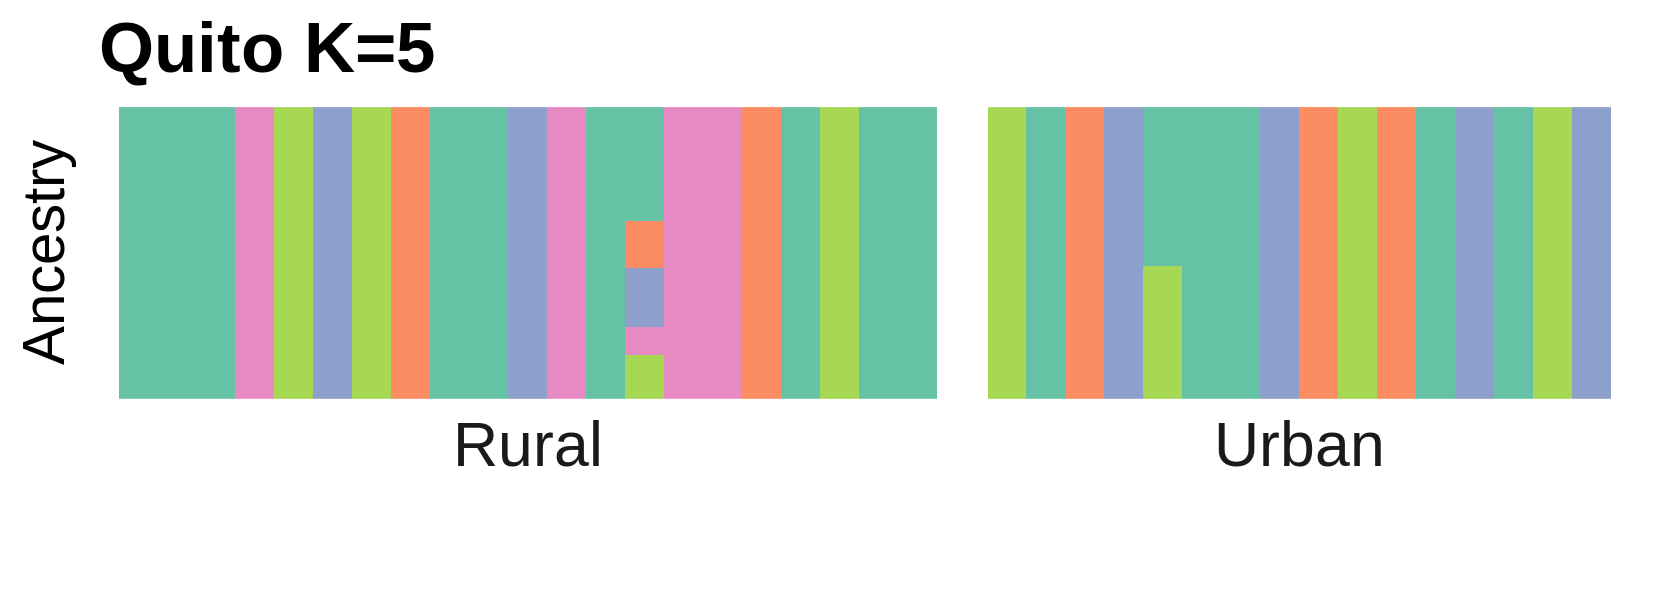

In [161]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X6) %>%
    bind_cols(., Quito_order_detail) %>% 
    pivot_longer(X1:X5, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Quito <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Quito K=5", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Quito_K5.png",
  plot = kplot_Quito,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Quito_K5.png"
display_png(file=path_to_kplot)

## Sapporo

[1] "Tue Dec  6 12:38:19 2022: Optimal K by Evanno is: 2"

[1] "2"

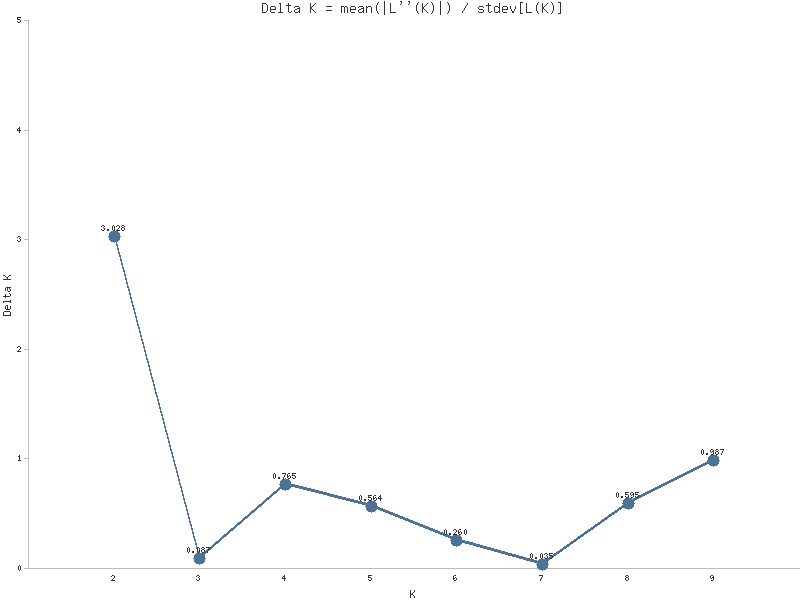

In [162]:
city <- 'Sapporo'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

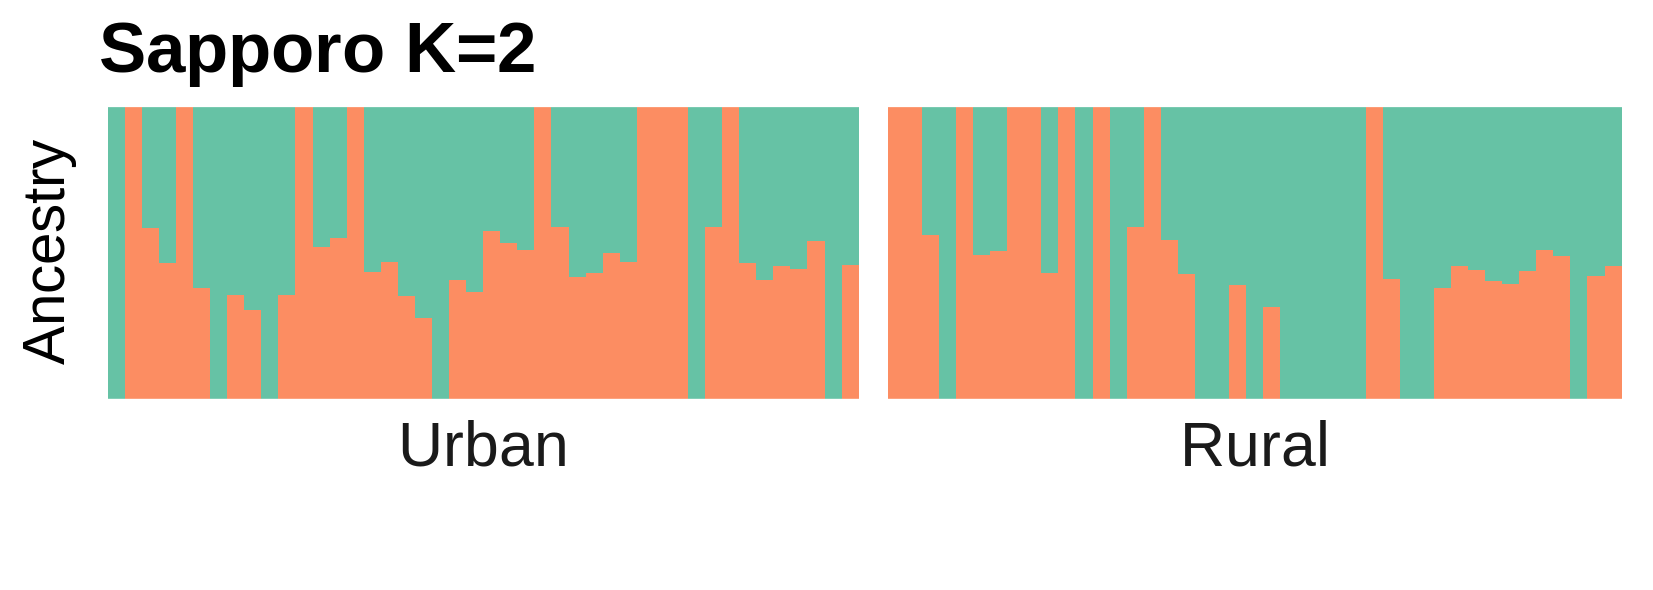

In [163]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Sapporo_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Sapporo <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Sapporo K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Sapporo_K2.png",
  plot = kplot_Sapporo,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Sapporo_K2.png"
display_png(file=path_to_kplot)

## Tehran

[1] "Tue Dec  6 17:12:02 2022: Optimal K by Evanno is: 2"

[1] "2"

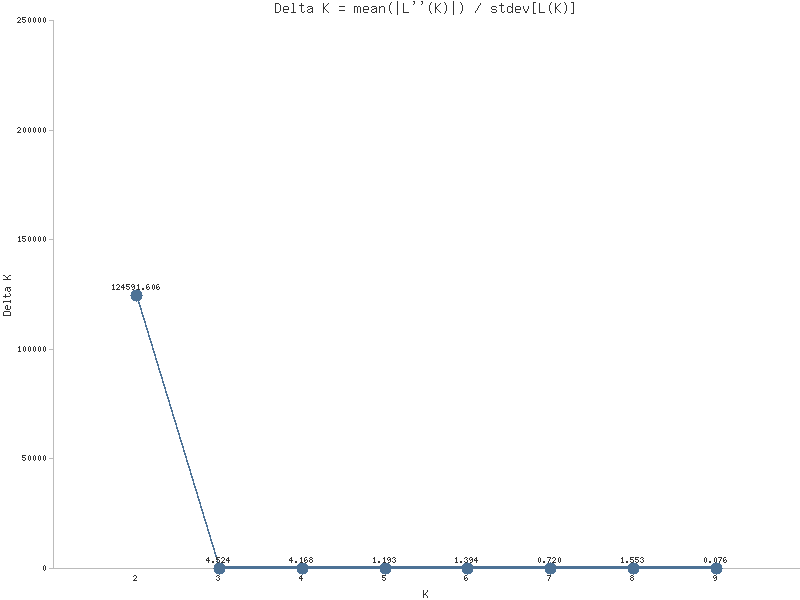

In [164]:
city <- 'Tehran'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



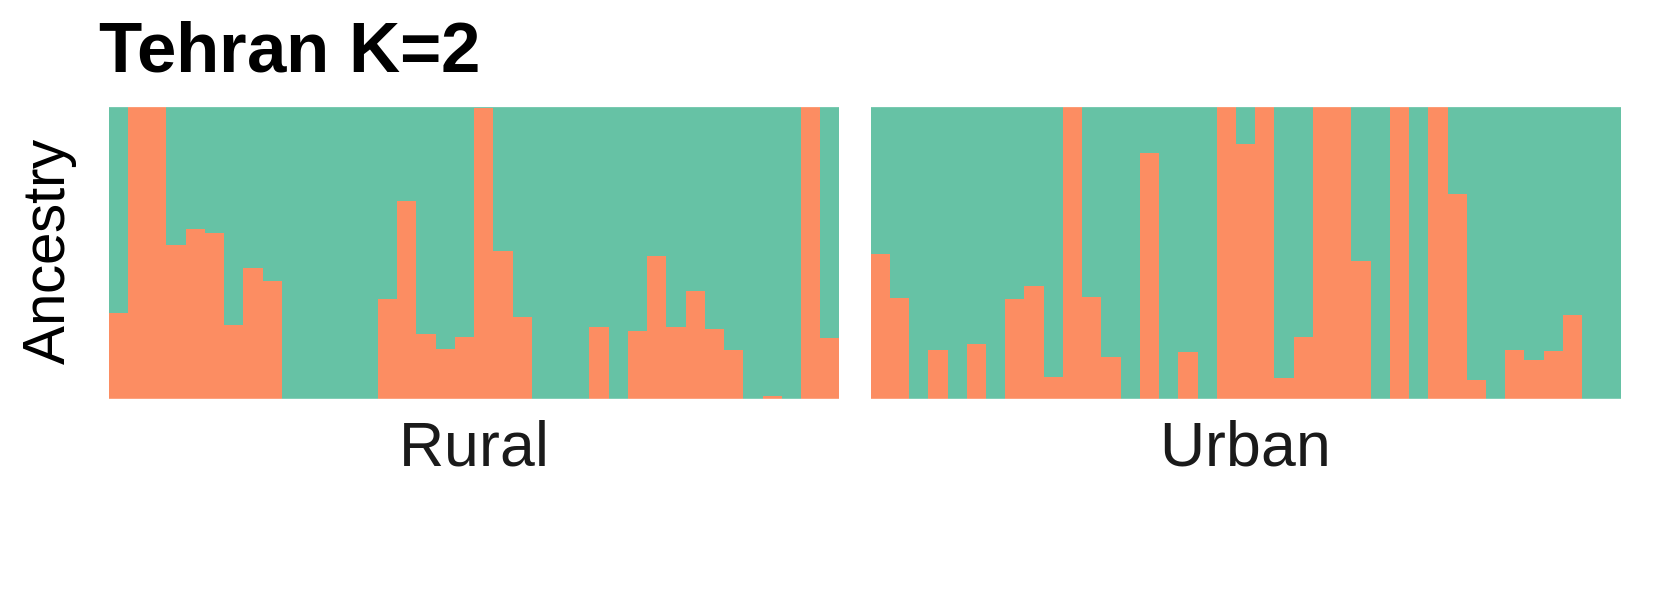

In [165]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Tehran_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))


kplot_Tehran <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Tehran K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Tehran_K2.png",
  plot = kplot_Tehran,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Tehran_K2.png"
display_png(file=path_to_kplot)

## Thessaloniki

[1] "Mon Dec  5 23:09:15 2022: Optimal K by Evanno is: 2"

[1] "2"

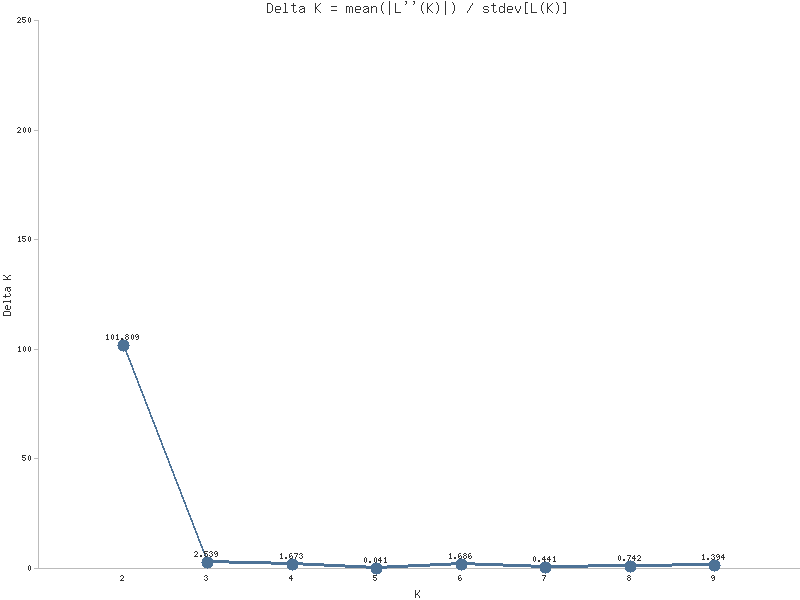

In [166]:
city <- 'Thessaloniki'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



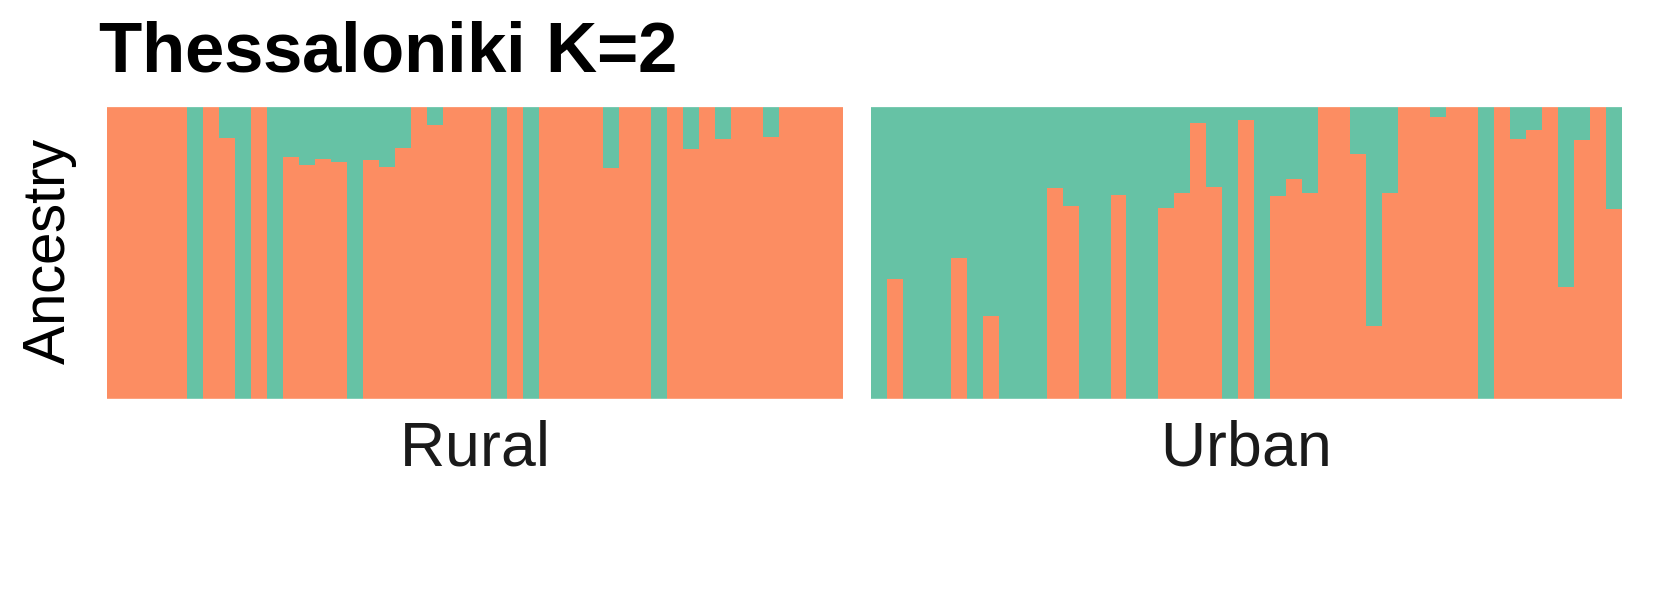

In [167]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Thessaloniki_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

kplot_Thessaloniki <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Thessaloniki K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Thessaloniki_K2.png",
  plot = kplot_Thessaloniki,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Thessaloniki_K2.png"
display_png(file=path_to_kplot)

## Toronto

[1] "Wed Dec  7 11:09:43 2022: Optimal K by Evanno is: 3"

[1] "3"

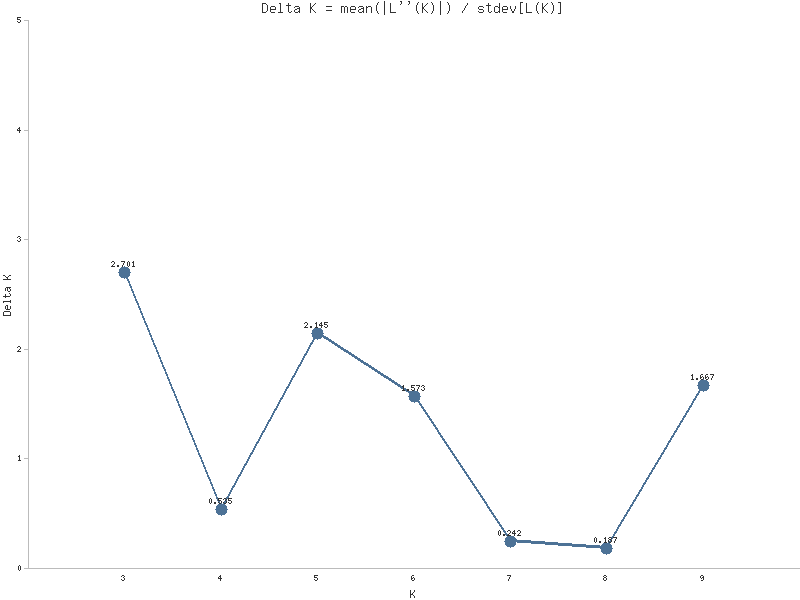

In [168]:
city <- 'Toronto'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])



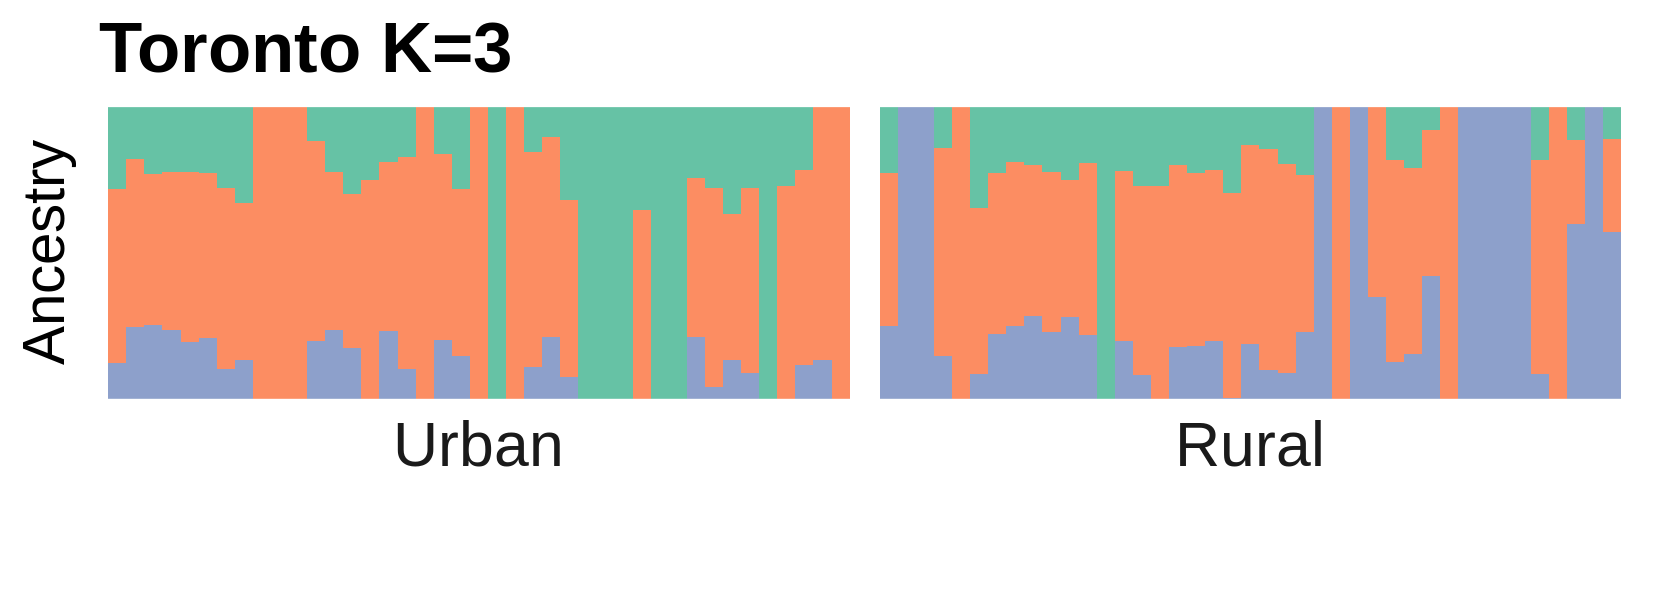

In [169]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., Toronto_order_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Toronto <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Toronto K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Toronto_K3.png",
  plot = kplot_Toronto,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Toronto_K3.png"
display_png(file=path_to_kplot)

## Vancouver

[1] "Sun Dec  4 18:42:26 2022: Optimal K by Evanno is: 2"

[1] "2"

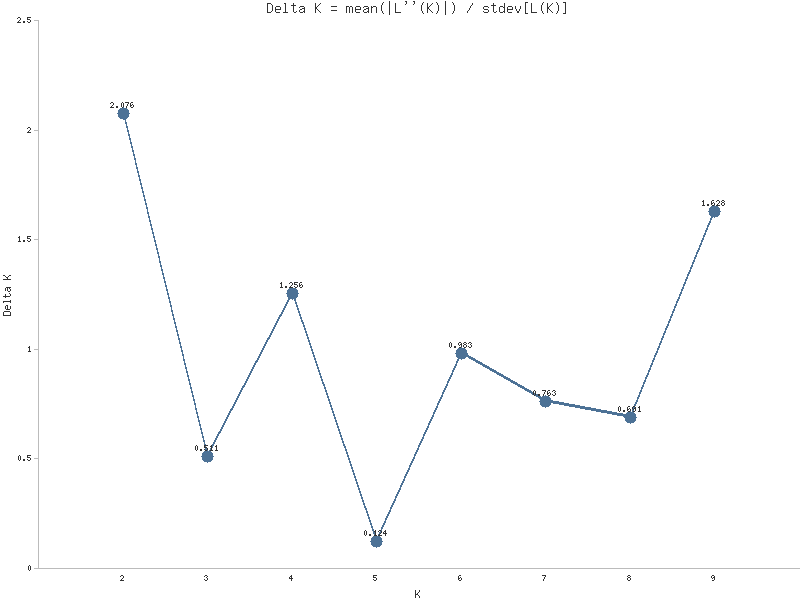

In [170]:
city <- 'Vancouver'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

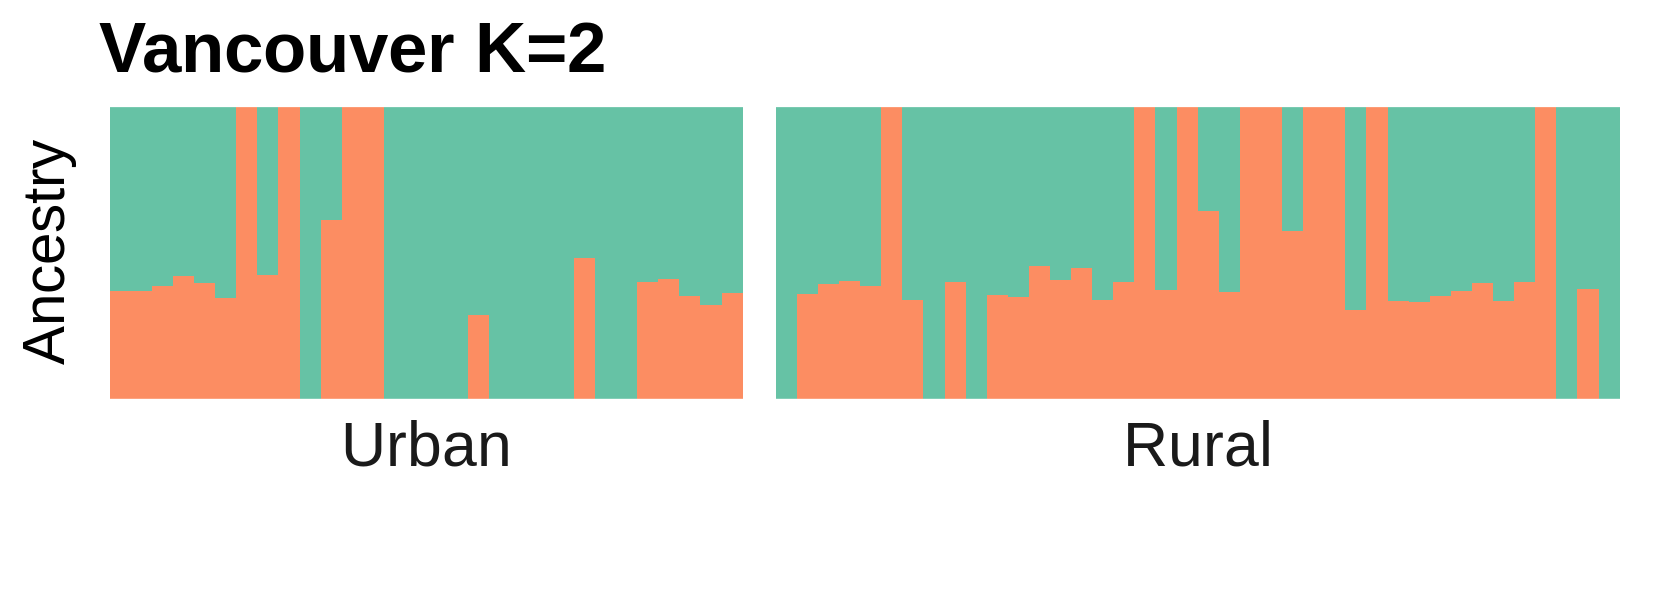

In [171]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X3) %>%
    bind_cols(., Vancouver_order_detail) %>% 
    pivot_longer(X1:X2, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

#cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Vancouver <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Vancouver K=2", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Vancouver_K2.png",
  plot = kplot_Vancouver,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Vancouver_K2.png"
display_png(file=path_to_kplot)

In [172]:
## Warsaw

[1] "Mon Nov 28 10:57:33 2022: Optimal K by Evanno is: 6"

[1] "6"

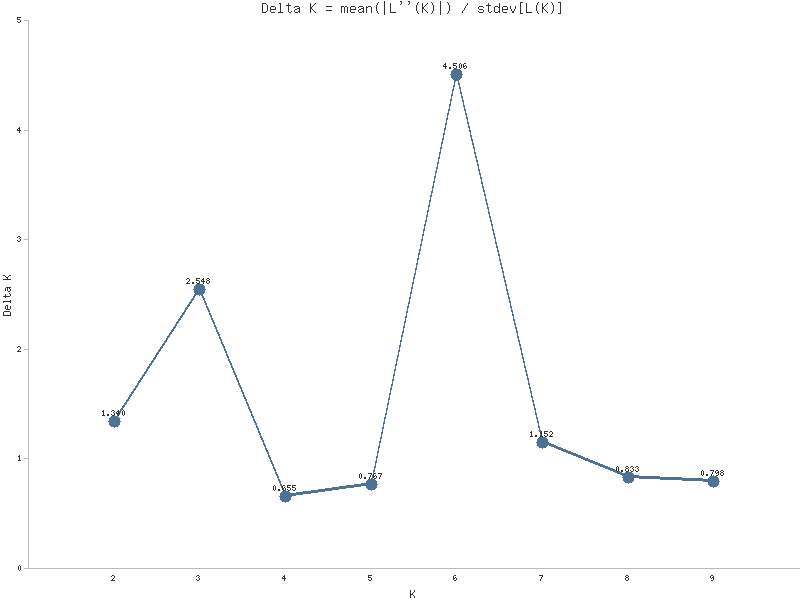

In [173]:
city <- 'Warsaw'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][11]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

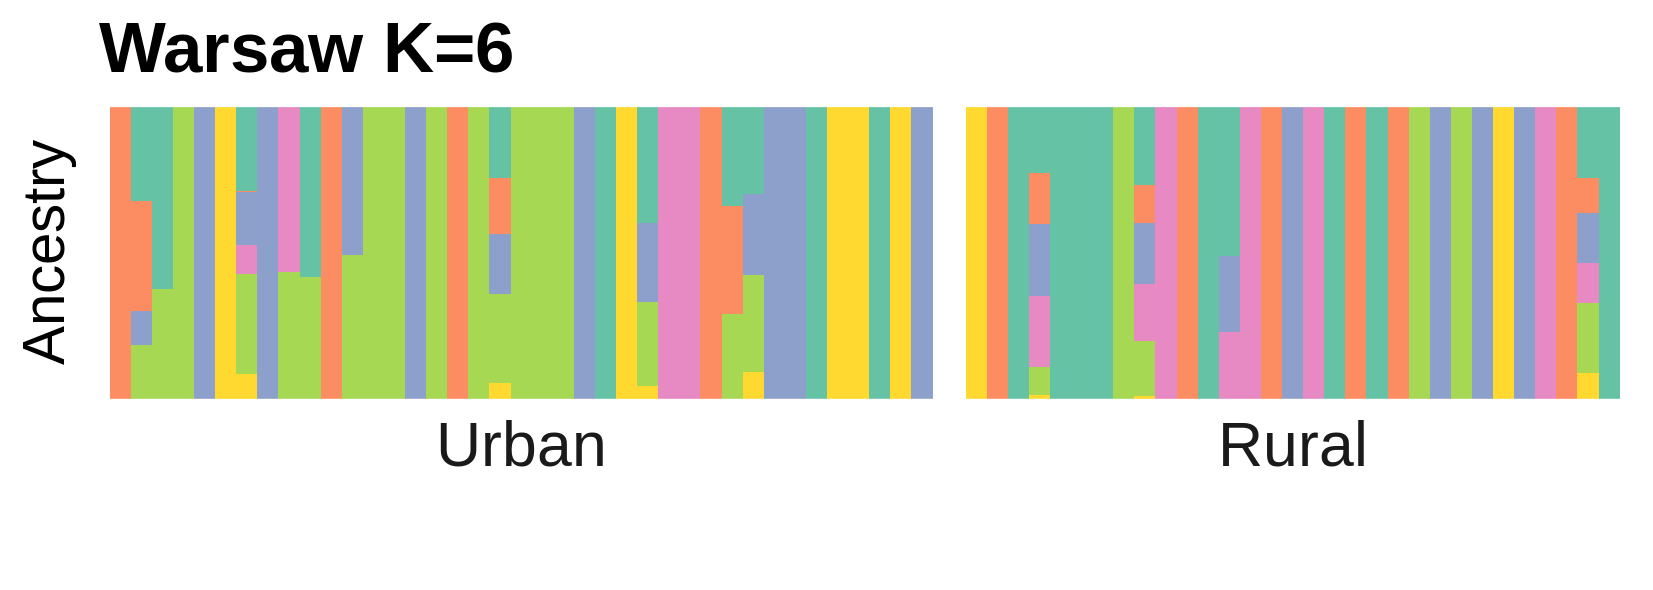

In [174]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_',city,'_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X7) %>%
    bind_cols(., Warsaw_order_detail) %>% 
    pivot_longer(X1:X6, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_Warsaw <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_inorder(site), scales = "free", switch = "x", space = "free") +
  theme_minimal() + labs(x="",title = "Warsaw K=6", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Warsaw_K6.png",
  plot = kplot_Warsaw,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 14,
  height = 5,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Warsaw_K6.png"
display_png(file=path_to_kplot)

## Combine plots

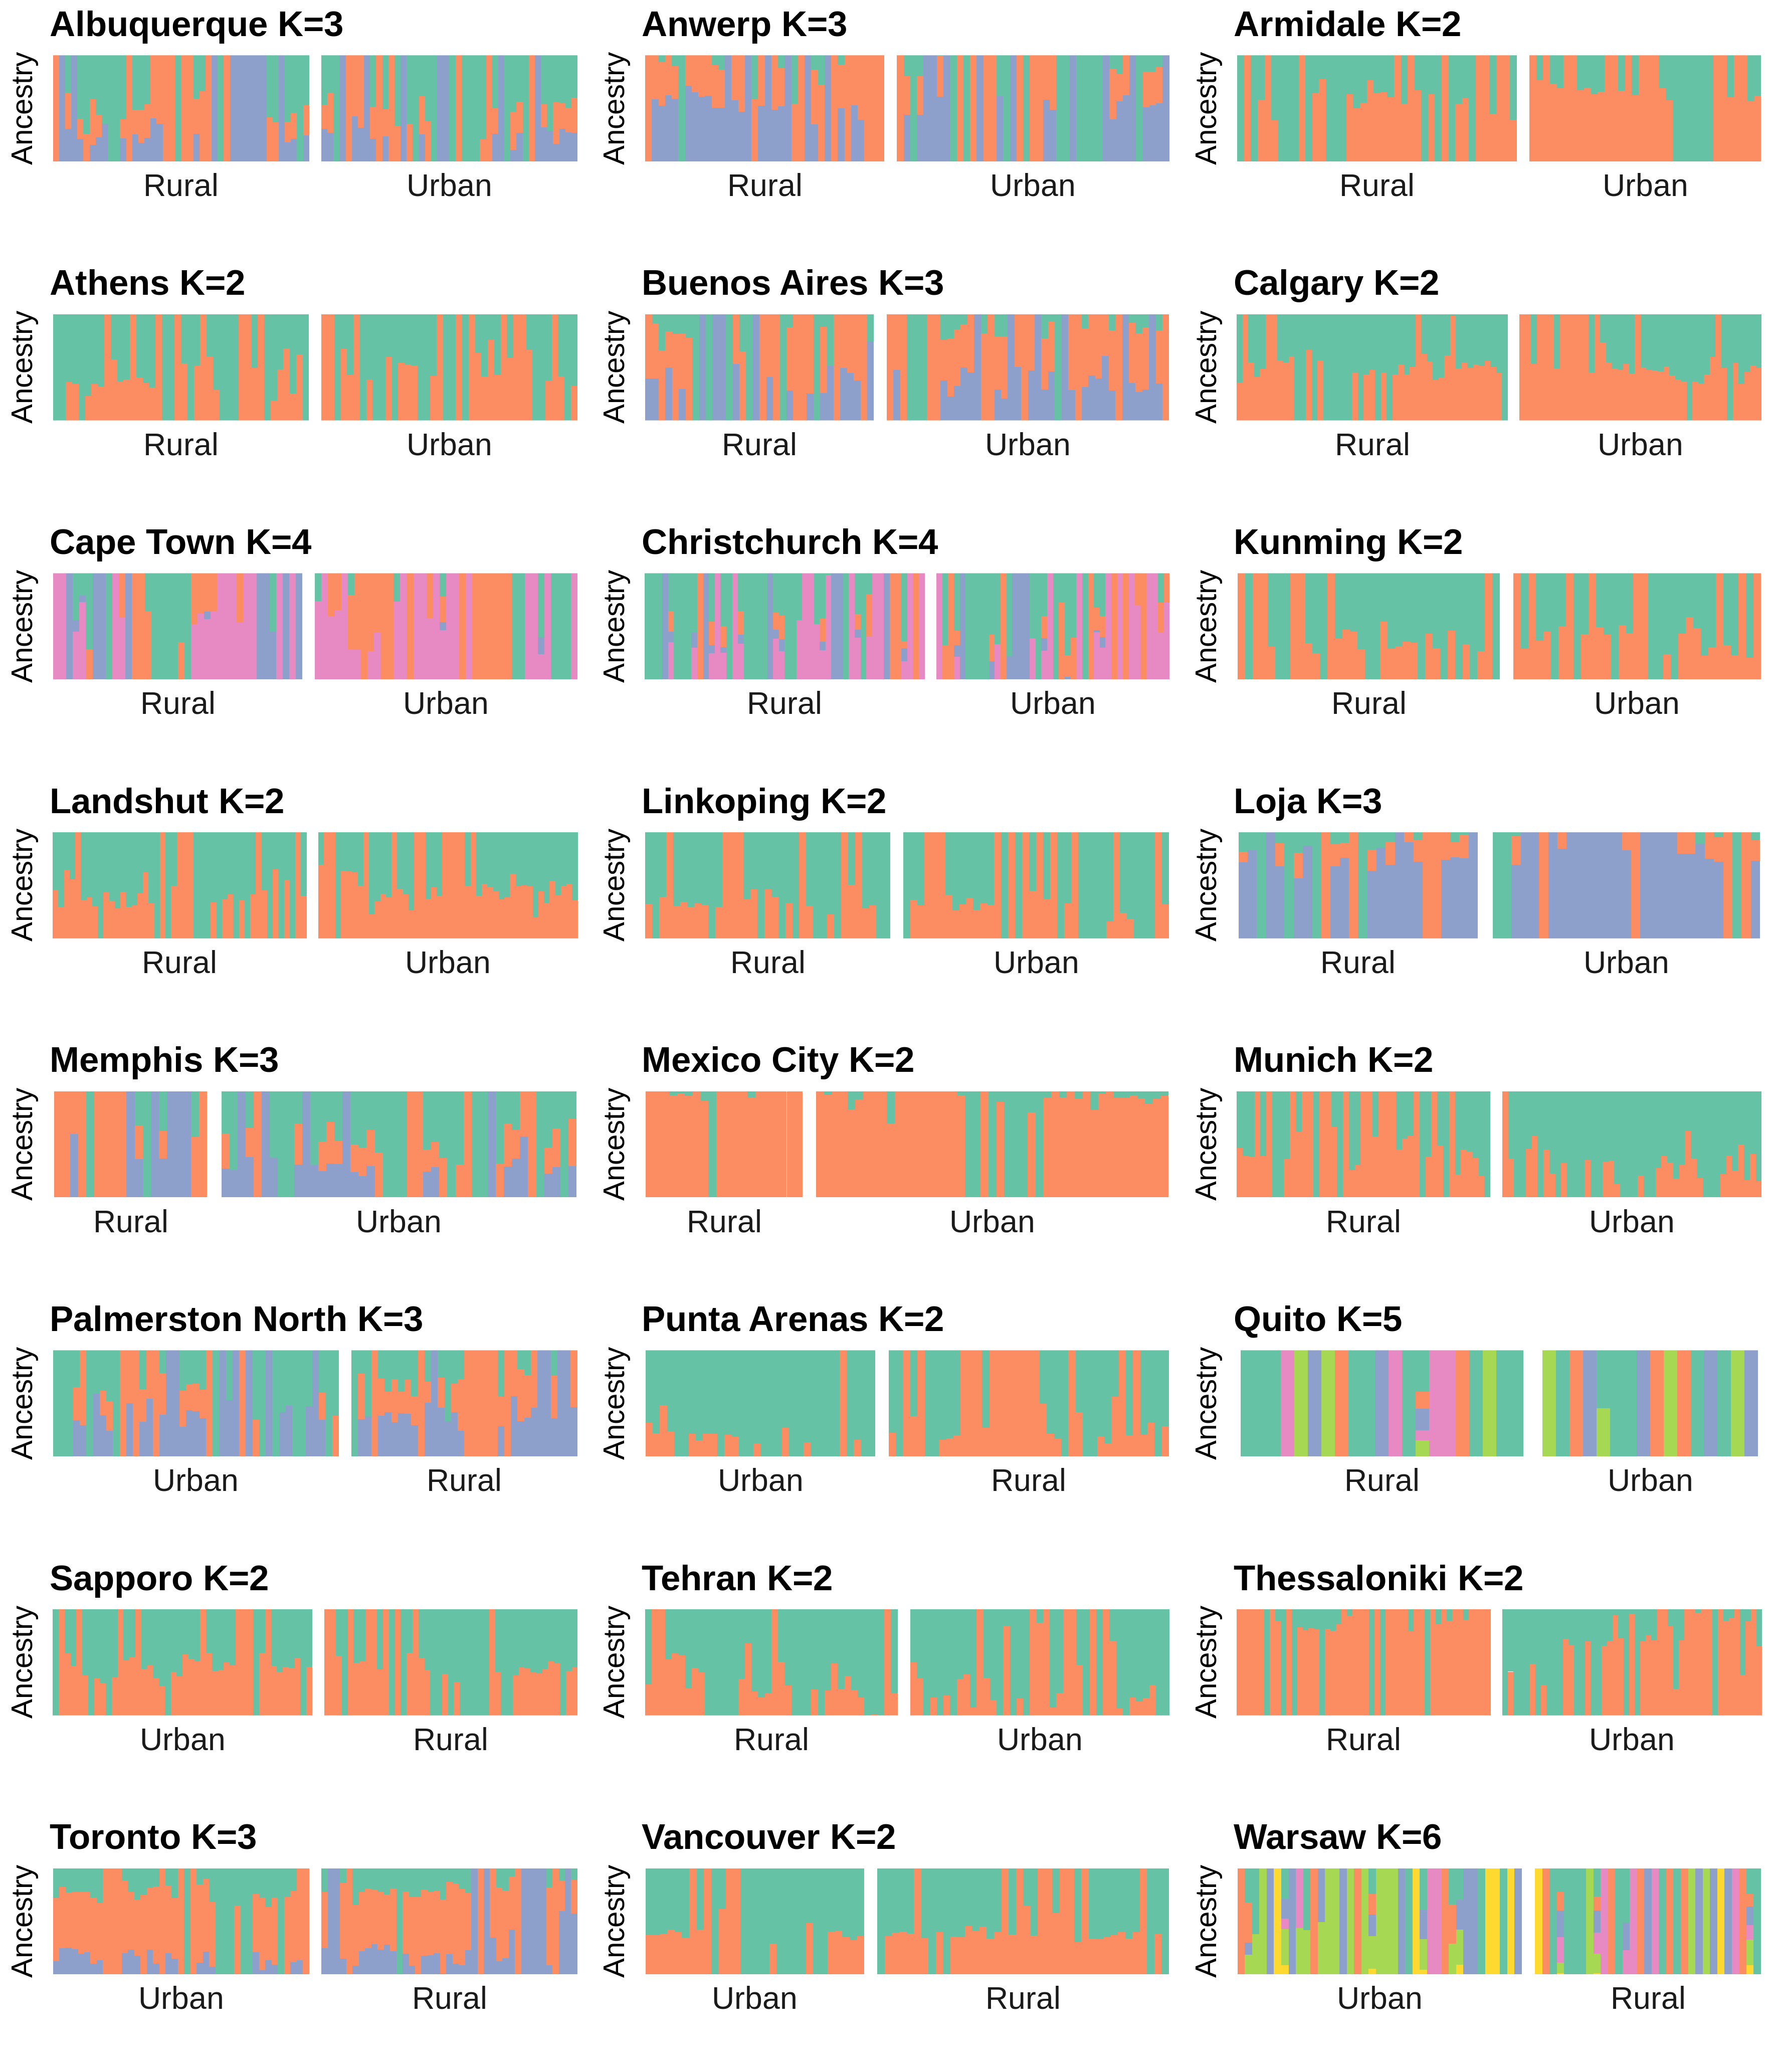

In [184]:
pannel<-ggarrange(kplot_Albuquerque, kplot_Antwerp, kplot_Armidale, kplot_Athens,
            kplot_Buenos_Aires,kplot_Calgary, kplot_Cape_Town, kplot_Christchurch,
            kplot_Kunming, kplot_Landshut, kplot_Linkoping, kplot_Loja,
            kplot_Memphis, kplot_Mexico_City, kplot_Munich, kplot_Palmerston_North,
            kplot_Punta_Arenas, kplot_Quito, kplot_Sapporo, kplot_Tehran,
            kplot_Thessaloniki, kplot_Toronto, kplot_Vancouver, kplot_Warsaw,
            ncol=3,nrow=8)
            
ggsave(
    "admixture_global.png",
    plot= pannel,
    device = png,
    path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
    width = 30,
    height = 35,
    units = "cm",
    dpi = 300
    )

path_to_admixtureplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/admixture_global.png"
display_png(file=path_to_admixtureplot)

    
    
    
    
    
    
    

# Global admixture

In [5]:
samples<-as.data.frame(read.table("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t"))
samples$site<-gsub("u","tem",as.character(samples$site))
samples$site<-gsub("r","Rural",as.character(samples$site))
samples$site<-gsub("tem","Urban",as.character(samples$site))

detail <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/withoutRelated/finalSamples_4fold_bams.list"))
detail$V1<-gsub("/scratch/projects/trifolium/glue/pc/results/bam/4fold/","",as.character(detail$V1))
detail$V1<-gsub("_4fold.bam","",as.character(detail$V1))
global_detail <-merge(samples, detail,  by.x="sample", by.y="V1", all.x=FALSE, all.y=TRUE, sort=FALSE) 
head(global_detail)


,sample,continent,city,pop,individual,site,range,library,lane
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
1,Albuquerque_29_5,NAM,Albuquerque,29,5,Rural,Introduced,glue_low1,1
2,Albuquerque_29_9,NAM,Albuquerque,29,9,Rural,Introduced,glue_low1,1
3,Albuquerque_32_13,NAM,Albuquerque,32,13,Rural,Introduced,glue_low1,1
4,Albuquerque_32_3,NAM,Albuquerque,32,3,Rural,Introduced,glue_low1,1
5,Albuquerque_33_2,NAM,Albuquerque,33,2,Rural,Introduced,glue_low1,1
6,Albuquerque_33_7,NAM,Albuquerque,33,7,Rural,Introduced,glue_low1,1


[1] "Wed Dec  7 14:04:28 2022: Optimal K by Evanno is: 3"

[1] "3"

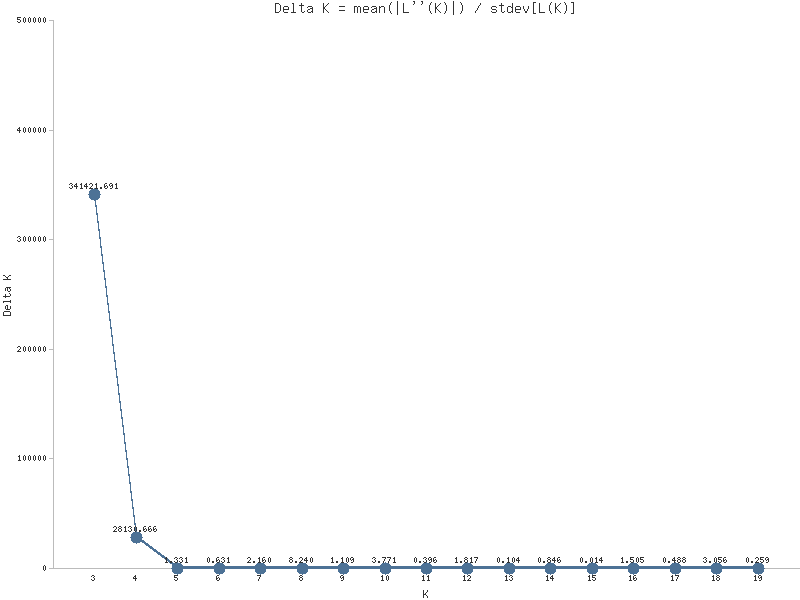

In [6]:
city <- 'global'

# Best K by Evanno
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/',city,'/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K
split<-strsplit(optimal_K, split = " ")
bestK<-split[[1]][12]
bestK

# Plot K
path_to_file<-paste0(results_prefix,'population_structure/bestKbyEvanno/',city,'/Best_K_By_Evanno-DeltaKByKGraph.png')
display_png(file=path_to_file)

# Load best K file
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

# Get lowest likelihood for plotting
min<-like_df %>%
    filter(like == min(like))
bestSeed<-as.character(min[1,1])

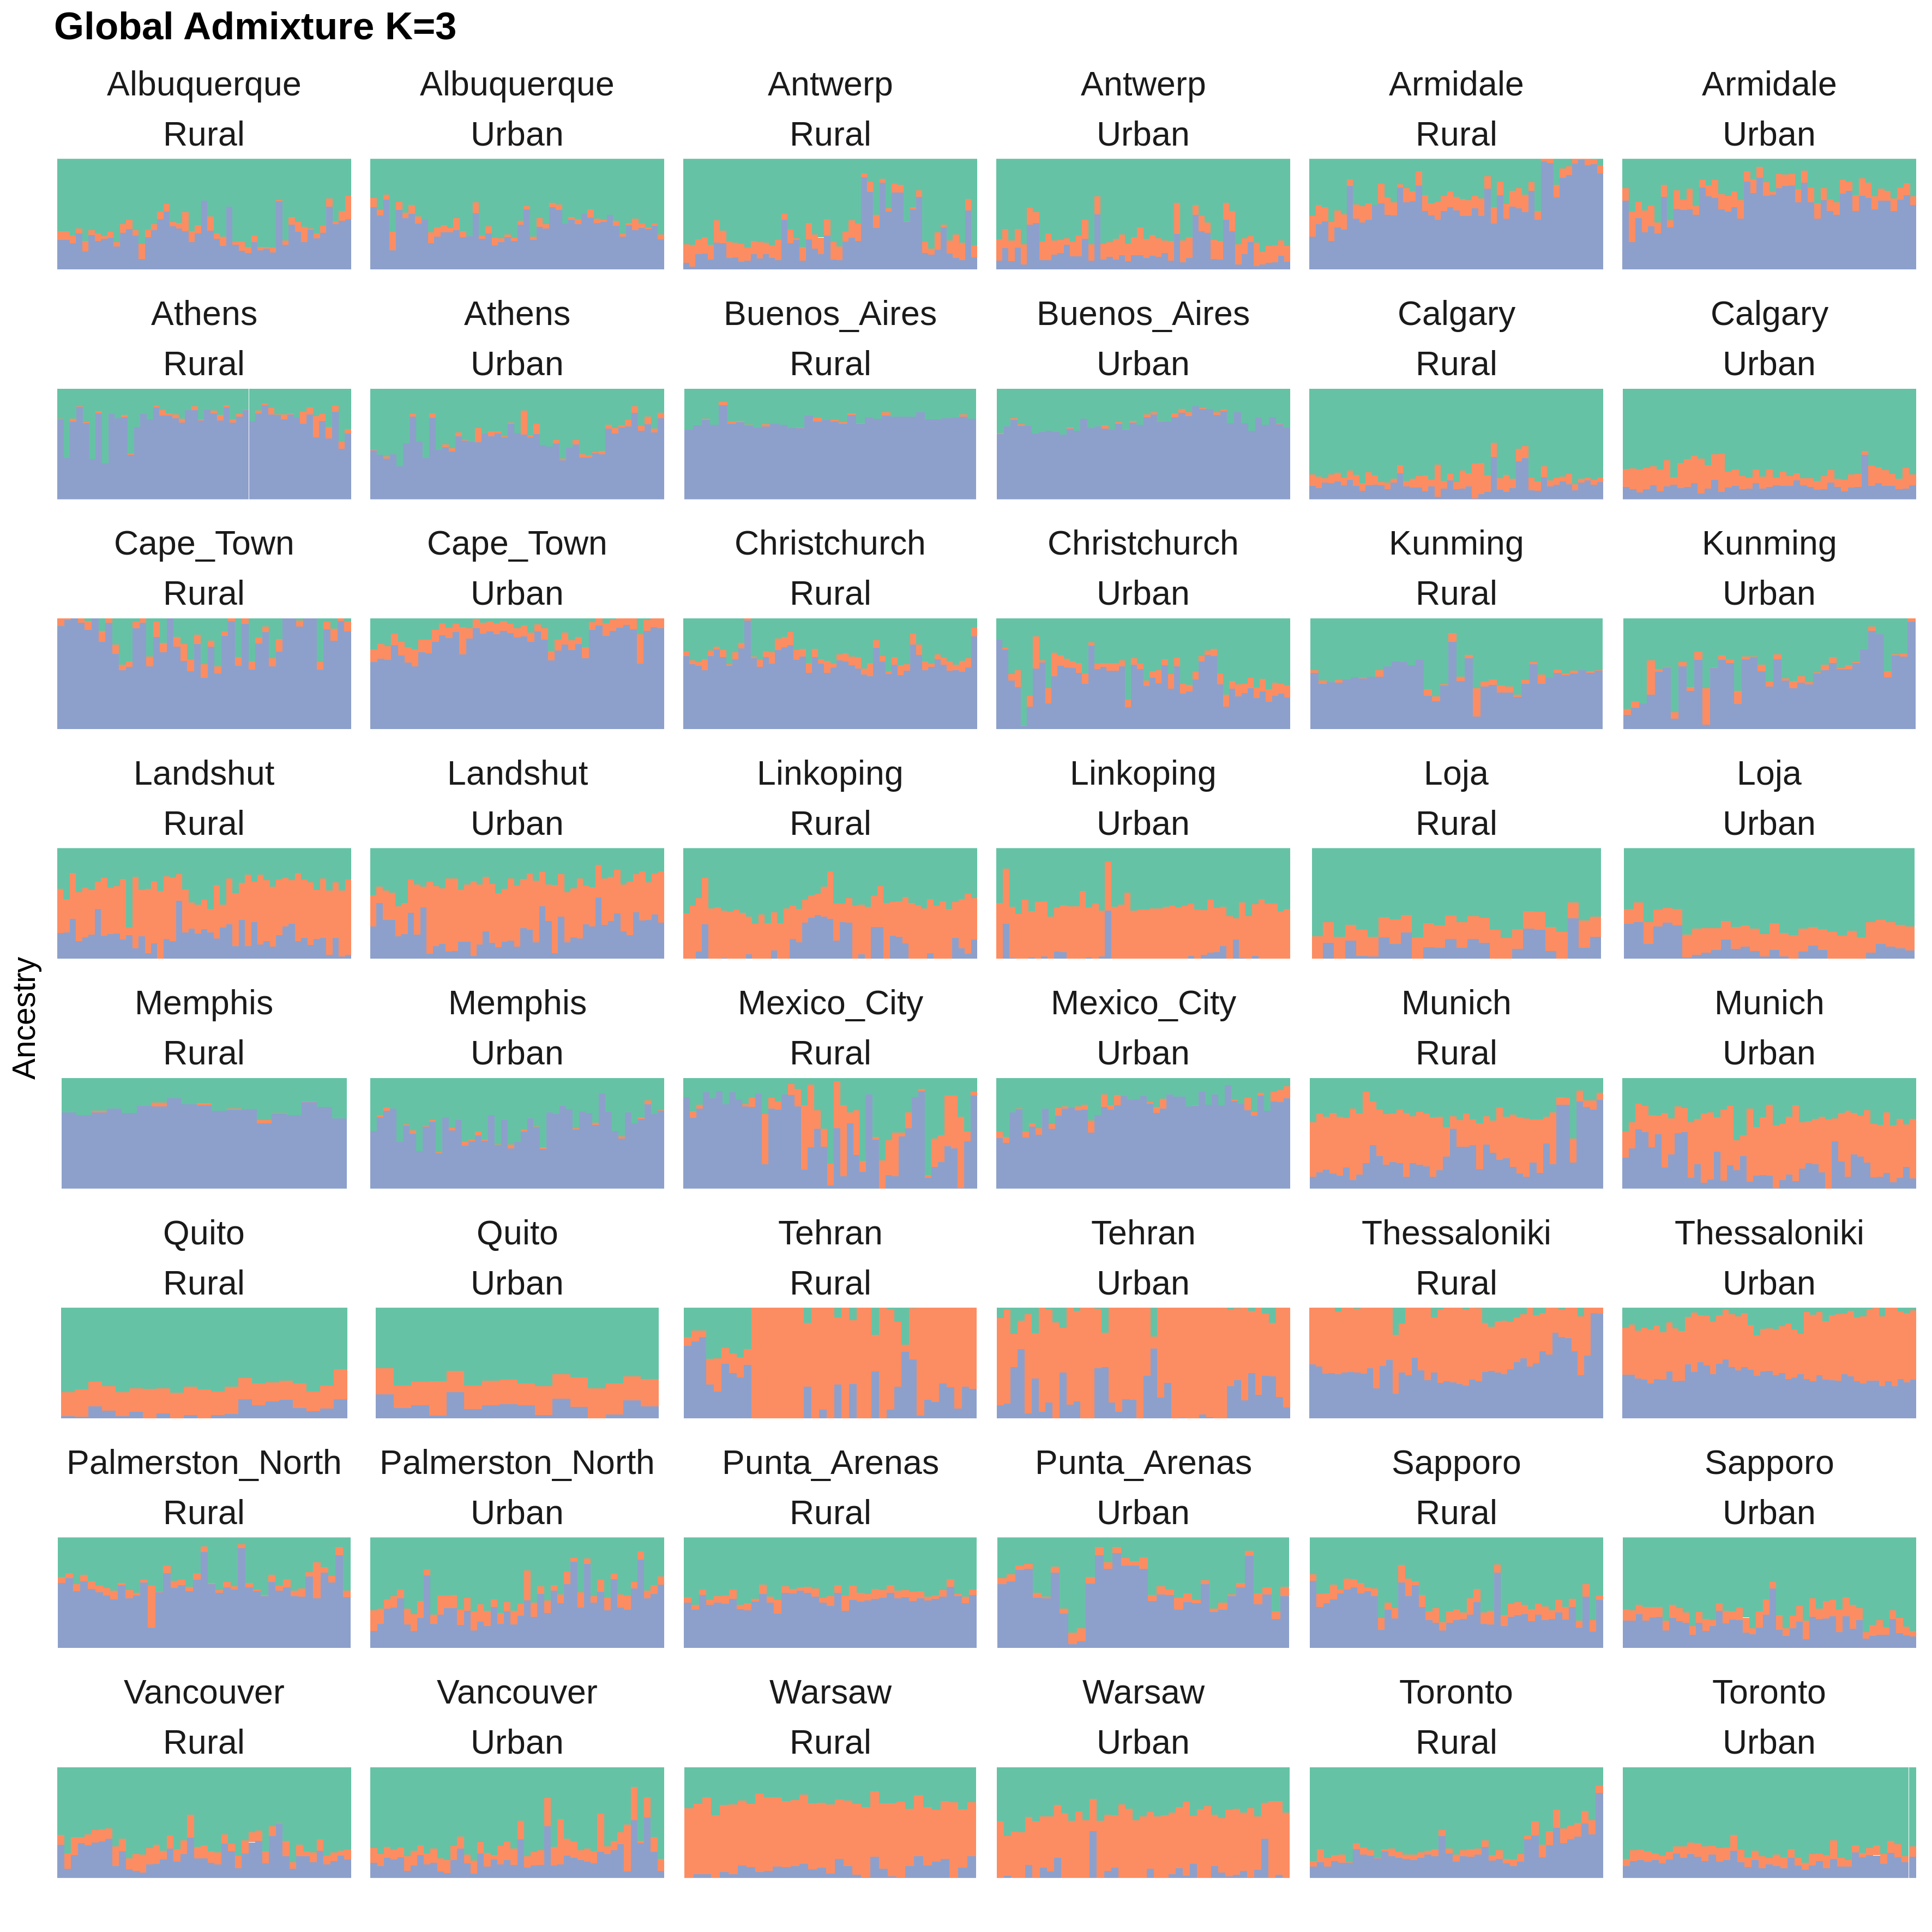

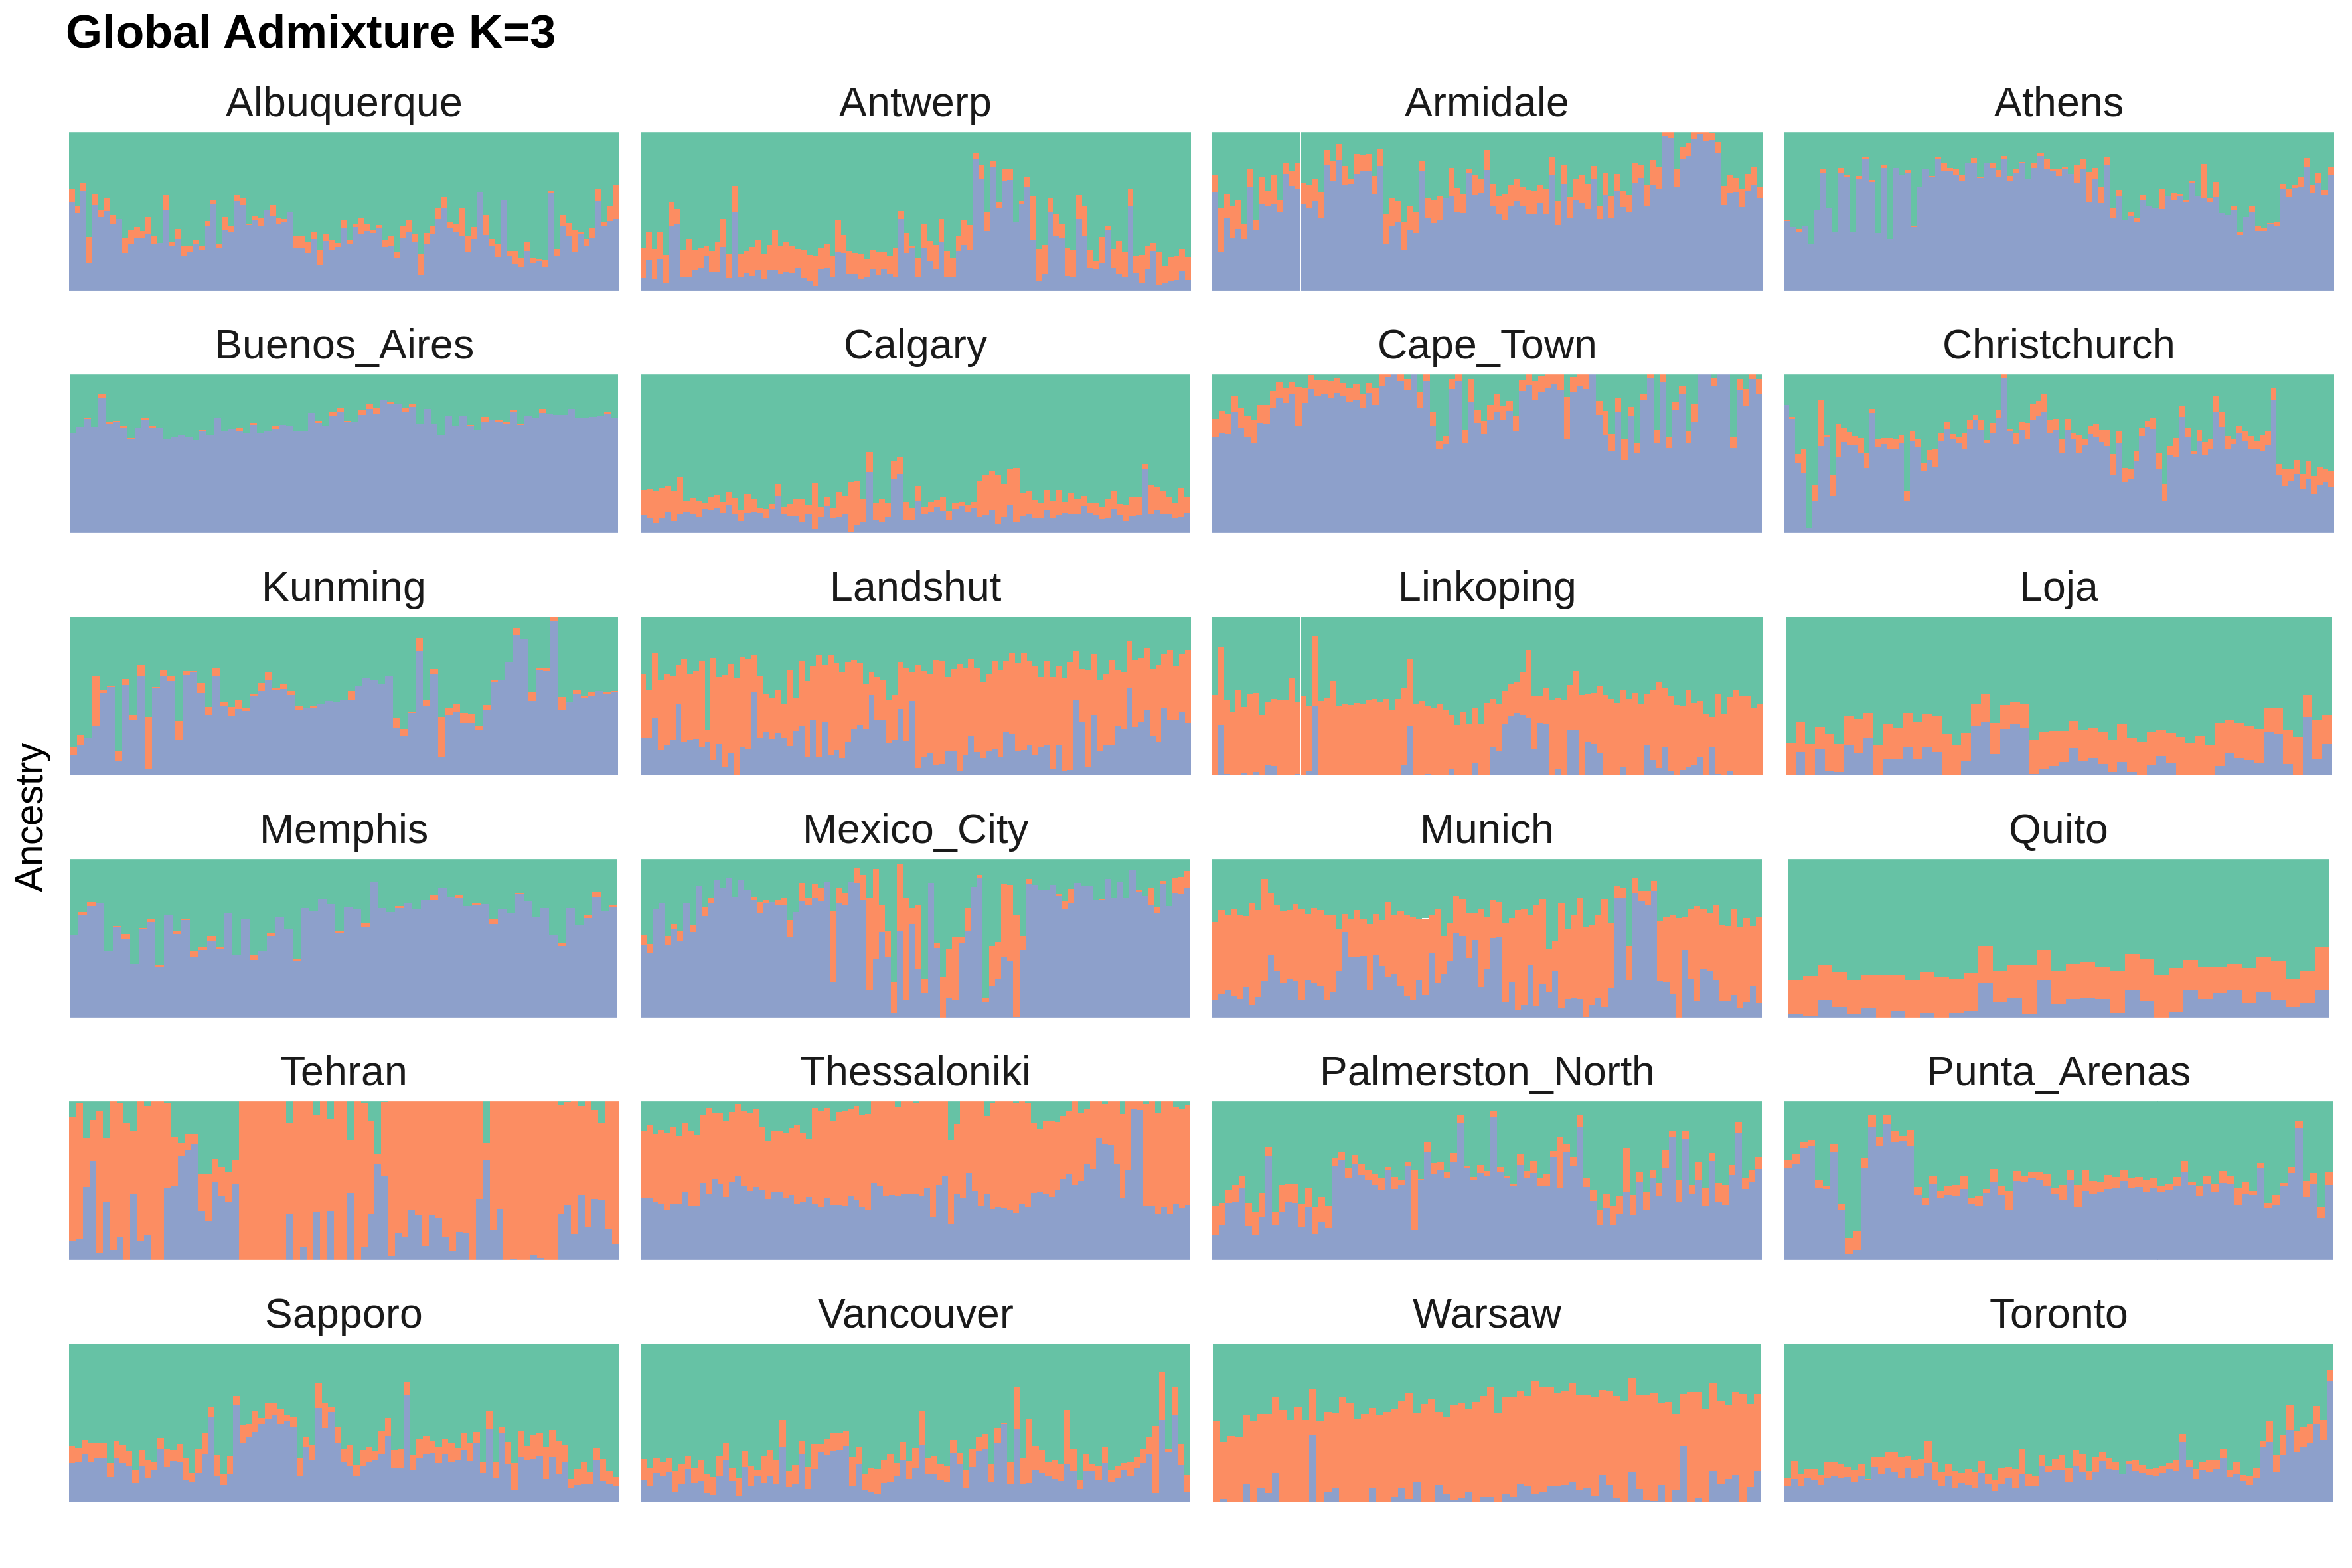

In [32]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/',city,'/K',bestK,'/ngsadmix_4fold_maf0.05_K',bestK,'_seed',bestSeed,'.qopt')

# /!\ CHANGE CITY NAME HERE /!\

admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X4) %>%
    bind_cols(., global_detail) %>% 
    pivot_longer(X1:X3, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))

cols_admix <- wes_palette("Darjeeling1", n=6, type = 'continuous')

kplot_global_city_hab <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_wrap(~fct_inorder(city)*site, scales = "free",ncol=6) +
  theme_minimal() + labs(x="",title = "Global Admixture K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Global_city_hab_K3.png",
  plot = kplot_global_city_hab,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 30,
  height = 30,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Global_city_hab_K3.png"
display_png(file=path_to_kplot)

kplot_global_city <-
  ggplot(admix, aes(factor(sample), Probs, fill = factor(name))) +
  geom_col(width=1) +
  facet_wrap(~fct_inorder(city), scales = "free",ncol=4) +
  theme_minimal() + labs(x="",title = "Global Admixture K=3", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
 #scale_fill_manual(values = cols_admix) + 
 #scale_color_manual(values = cols_admix) +
  scale_fill_brewer(palette="Set2")+
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.2, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=10),
    axis.title = element_text(size=14),
    strip.text.x = element_text(size = 15),
    plot.title = element_text(size = 17, face = 'bold'),
    axis.text.y = element_blank()
  ) 

ggsave(
  "ADMIX_Global_city_K3.png",
  plot = kplot_global_city,
  device = png,
  path = "/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/",
  width = 30,
  height = 20,
  units = "cm",
  dpi = 300
)

path_to_kplot<-"/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/admixture/ADMIX_Global_city_K3.png"
display_png(file=path_to_kplot)
